In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from skimage import io
import seaborn as sns

from microscopy import utils 

import omegaconf

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

def translate_yaml(yaml_path):

    confg = omegaconf.OmegaConf.load(yaml_path)

    result = {}

    try:
        hyperparams = confg.pop('used_optim_d')
        result.update(hyperparams)
    except:
        if 'used_optim_d' in confg:
            del confg['used_optim_d']
        
    hyperparams = confg.pop('used_optim')
    result.update(hyperparams)
    
    try:
        hyperparams = confg.pop('used_sched_d')
        result.update(hyperparams)
    except:
        if 'used_sched_d' in confg:
            del confg['used_sched_d']

    try:
        hyperparams = confg.pop('used_sched')
        result.update(hyperparams)
    except:
        if 'used_sched' in confg:
            del confg['used_sched']

    hyperparams = confg.pop('used_model')
    result.update(hyperparams)
    hyperparams = confg.pop('used_dataset')
    result.update(hyperparams)

    patience = confg.pop('model.optim.early_stop.patience')
    result.update({'patience':patience})
    
    hyperparams = confg.pop('hyperparam')
    result.update(hyperparams)
    
    confg.pop('dataset')
    confg.pop('model')
    
    result.update(confg)

    result.pop('data_paths')
    
    return result

def load_test_results(test_metrics_path):
    metric_dict= {}
    
    for metric in os.listdir(test_metrics_path):
        metric_name = metric[:-4]
        metric_data = np.load(os.path.join(test_metrics_path, metric))
        metric_dict[f'{metric_name}_mean'] = np.mean(metric_data) if len(metric_data) > 0 else 0
        metric_dict[f'{metric_name}_std'] = np.std(metric_data) if len(metric_data) > 0 else 0
    return metric_dict
        

def sorted_imgs_by_epoch(filename_list):
    epochs = [int(e[:-4]) for e in filename_list]
    return [f'{e}.png' for e in sorted(epochs)]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/ihidalgo/miniconda3/envs/microscopy/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ihidalgo/miniconda3/envs/microscopy/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/ihidalgo/miniconda3/envs/microscopy/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/ihidalgo/miniconda3/envs/microscopy/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/ihidalgo/miniconda3/envs/microscopy/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth
Selecting OpenCL device: NVIDIA GeForce RTX 2080 Ti


/home/ihidalgo/miniconda3/envs/microscopy/lib/python3.9/site-packages/nanopyx/liquid/__njit__.py:15: UserWarning: Numba is not installed. Using pure python for _njit_interpolate
  warnings.warn(
/home/ihidalgo/miniconda3/envs/microscopy/lib/python3.9/site-packages/nanopyx/liquid/__njit__.py:15: UserWarning: Numba is not installed. Using pure python for njit_shift_magnify
  warnings.warn(
/home/ihidalgo/miniconda3/envs/microscopy/lib/python3.9/site-packages/nanopyx/liquid/__njit__.py:15: UserWarning: Numba is not installed. Using pure python for njit_shift_scale_rotate
  warnings.warn(
/home/ihidalgo/miniconda3/envs/microscopy/lib/python3.9/site-packages/nanopyx/liquid/_le_mandelbrot_benchmark_.py:17: UserWarning: Numba is not installed. Using pure python for _njit_mandelbrot
  warnings.warn(
/home/ihidalgo/miniconda3/envs/microscopy/lib/python3.9/site-packages/nanopyx/liquid/_le_mandelbrot_benchmark_.py:17: UserWarning: Numba is not installed. Using pure python for njit_mandelbrot
  wa

2.8.4


In [7]:
def load_dataframe():
    results_path = os.path.abspath('results')

    if not os.path.exists(results_path):
        raise ValueError('There is no results folder.')

    dataset_list = os.listdir(results_path)
    dataset_path_list = [os.path.join(results_path, e) for e in os.listdir(results_path)]

    all_results = {}

    for dataset, dataset_path in zip(dataset_list, dataset_path_list):
        model_list = os.listdir(dataset_path)
        model_path_list = [os.path.join(dataset_path, e) for e in os.listdir(dataset_path)]
        for model, model_path in zip(model_list, model_path_list):
            additfolder_list = os.listdir(model_path)
            additfolder_path_list = [os.path.join(model_path, e) for e in os.listdir(model_path)]
            cont = 0
            for additfolder, additfolder_path in zip(additfolder_list, additfolder_path_list):
                config_list = os.listdir(additfolder_path)
                config_path_list = [os.path.join(additfolder_path, e) for e in os.listdir(additfolder_path)]
                for config, config_path in zip(config_list, config_path_list):
                    yaml_path = os.path.join(config_path, 'train_configuration.yaml')
                    test_metrics_path = os.path.join(config_path, 'test_metrics')
                    
                    if os.path.exists(yaml_path) and os.path.exists(test_metrics_path):
                        # hydra_conf = omegaconf.OmegaConf.load('/data/ihidalgo/MicroscoPy/conf/config.yaml')
                        # hydra_dict = omegaconf.OmegaConf.to_container(hydra_conf, resolve=True)

                        # yaml_data.update(load_test_results(test_metrics_path))
                        # yaml_data.update({'config_path': config_path})
                        hydra_conf = translate_yaml(yaml_path)
                        hydra_conf.update(load_test_results(test_metrics_path))
                        hydra_conf.update({'config_path': config_path})
                        all_results[f'{model}_{dataset}_{cont}'] = hydra_conf

                        cont += 1

    return pd.DataFrame(all_results).T

df = load_dataframe()    
df.head()

beta1 beta2 epsilon g_layers lambda_gp recloss      crappifier  \
wgan_ER_0   0.5   0.9     0.0       15        10   100.0  downsampleonly   
wgan_ER_1   0.5   0.9     0.0       15        10   100.0  downsampleonly   
wgan_ER_2   0.5   0.9     0.0       15        10   100.0  downsampleonly   
wgan_ER_3   0.5   0.9     0.0       15        10   100.0  downsampleonly   
wgan_ER_4   0.5   0.9     0.0       15        10   100.0  downsampleonly   

          patch_size_x patch_size_y scale patience  \
wgan_ER_0           64           64  None       50   
wgan_ER_1           64           64  None      100   
wgan_ER_2           64           64  None       50   
wgan_ER_3           64           64  None       50   
wgan_ER_4           64           64  None      500   

                              test_metric_indexes optimizer  \
wgan_ER_0  [69, 7, 36, 75, 74, 30, 12, 42, 87, 0]      adam   
wgan_ER_1  [69, 7, 36, 75, 74, 30, 12, 42, 87, 0]      adam   
wgan_ER_2  [69, 7, 36, 75, 74, 30, 12, 42, 87, 0]      adam   
wgan_ER_3  [69, 7, 36, 75, 74, 30, 12, 42, 87, 0]      adam   
wgan_ER_4  [69, 7, 36, 75, 74, 30, 12, 42, 87, 0]      adam   

          discriminator_optimizer scheduler discriminator_lr_scheduler  \
wgan_ER_0                    adam  OneCycle                   OneCycle   
wgan_ER_1                    adam  OneCycle                   OneCycle   
wgan_ER_2                    adam  OneCycle                   OneCycle   
wgan_ER_3                    adam  OneCycle                   OneCycle   
wgan_ER_4                    adam  OneCycle                   OneCycle   

               lr discriminator_lr seed batch_size num_epochs  \
wgan_ER_0  0.0001           0.0001  666          4         50   
wgan_ER_1  0.0005           0.0005  666          4        100   
wgan_ER_2   0.001            0.001  666          8         50   
wgan_ER_3  0.0005           0.0005  666          1         50   
wgan_ER_4  0.0001            0.001  666          4        500   

          validation_split additional_folder  \
wgan_ER_0              0.1              None   
wgan_ER_1              0.1              None   
wgan_ER_2              0.1              None   
wgan_ER_3              0.1              None   
wgan_ER_4              0.1              None   

                                    data_augmentation datagen_sampling_pdf  \
wgan_ER_0  [rotation, horizontal_flip, vertical_flip]                    0   
wgan_ER_1  [rotation, horizontal_flip, vertical_flip]                    0   
wgan_ER_2  [rotation, horizontal_flip, vertical_flip]                    0   
wgan_ER_3  [rotation, horizontal_flip, vertical_flip]                    0   
wgan_ER_4  [rotation, horizontal_flip, vertical_flip]                    0   

          dataset_name model_name actual_scale_factor  vgg_mean   vgg_std  \
wgan_ER_0           ER       wgan                   2  0.483446  0.064616   
wgan_ER_1           ER       wgan                   2  0.468243  0.058316   
wgan_ER_2           ER       wgan                   2  0.500593  0.048143   
wgan_ER_3           ER       wgan                   2  0.465081  0.059877   
wgan_ER_4           ER       wgan                   2  0.582481  0.019021   

           mse_mean   mse_std alex_mean  alex_std  psnr_mean  psnr_std  \
wgan_ER_0  0.007114  0.001889  0.309551   0.07685  21.639806  1.200566   
wgan_ER_1  0.007416  0.001801   0.31338  0.072124  21.433869  1.105012   
wgan_ER_2  0.007986  0.001878  0.305239  0.076131  21.098867  1.037383   
wgan_ER_3  0.007351  0.002753  0.353047   0.06884  21.626723  1.577589   
wgan_ER_4  0.007779  0.001821  0.348821  0.059179  21.215999  1.058847   

          ssim_mean  ssim_std  \
wgan_ER_0  0.569473  0.125326   
wgan_ER_1  0.564133  0.117739   
wgan_ER_2  0.530686  0.125455   
wgan_ER_3  0.546282  0.142411   
wgan_ER_4  0.523288  0.106994   

                                                 config_path  \
wgan_ER_0  /data/ihidalgo/MicroscoPy/results/ER/wgan/scal...   
wgan_ER_1  /data/ihi

In [8]:
print('Different tested hyperparameters:')

print(f'lr: {sorted(df.lr.unique())}')
print(f'batch_size: {sorted(df.batch_size.unique())}')
print(f'num_epochs: {sorted(df.num_epochs.unique())}')
print(f'dataset_name: {sorted(df.dataset_name.unique())}')
print(f'model_name: {sorted(df.model_name.unique())}')

Different tested hyperparameters:
lr: [0.0001, 0.0002, 0.0005, 0.001, 0.005]
batch_size: [1, 2, 4, 8, 16]
num_epochs: [1, 10, 50, 100, 200, 500]
dataset_name: ['ER', 'F-actin', 'LiveFActinDataset', 'MT']
model_name: ['dfcan', 'rcan', 'unet', 'wdsr', 'wgan']


In [9]:
# All possible configurations (not showing columns with single repeated value)
visualize_df = df.copy()
nunique = visualize_df.nunique()
cols_to_drop = nunique[nunique == 1].index
visualize_df.drop(cols_to_drop, axis=1)

patch_size_x patch_size_y scale patience  \
wgan_ER_0                            64           64  None       50   
wgan_ER_1                            64           64  None      100   
wgan_ER_2                            64           64  None       50   
wgan_ER_3                            64           64  None       50   
wgan_ER_4                            64           64  None      500   
wgan_ER_5                            64           64  None      500   
wgan_ER_6                            64           64  None       50   
wgan_ER_7                            64           64  None       50   
wgan_ER_8                            64           64  None       50   
wgan_ER_9                            64           64  None      500   
wgan_ER_10                           64           64  None       50   
wgan_ER_11                           64           64  None       50   
wgan_ER_12                           64           64  None      200   
wgan_ER_13                           64           64  None       50   
wgan_ER_14                           64           64  None       50   
wgan_ER_15                           64           64  None       50   
wgan_ER_16                           64           64  None      100   
wgan_ER_17                           64           64  None       50   
wgan_ER_18                           64           64  None      200   
wgan_ER_19                           64           64  None       50   
wgan_ER_20                           64           64  None       50   
wgan_ER_21                           64           64  None       50   
wgan_ER_22                           64           64  None       50   
wdsr_ER_0                            64           64  None       10   
wdsr_ER_1                            64           64  None       10   
wdsr_ER_2                            64           64  None       10   
wdsr_ER_3                            64           64  None       10   
wdsr_ER_4                            64           64  None       10   
wdsr_ER_5                            64           64  None       10   
wdsr_ER_6                            64           64  None       10   
wdsr_ER_7                            64           64  None       10   
wdsr_ER_8                            64           64  None       10   
wdsr_ER_9                            64           64  None       10   
wdsr_ER_10                           64           64  None       10   
wdsr_ER_11                           64           64  None       10   
wdsr_ER_12                           64           64  None       10   
wdsr_ER_13                           64           64  None       10   
wdsr_ER_14                           64           64  None       10   
wdsr_ER_15                           64           64  None       10   
dfcan_ER_0                           64           64  None       10   
dfcan_ER_1                           64           64  None       10   
dfcan_ER_2                           64           64  None       10   
dfcan_ER_3                           64           64  None       10   
dfcan_ER_4                           64           64  None       10   
dfcan_ER_5                           64           64  None       10   
dfcan_ER_6                           64           64  None       10   
dfcan_ER_7                           64           64  None       10   
dfcan_ER_8                           64           64  None       10   
dfcan_ER_9                           64           64  None       10   
dfcan_ER_10                          64           64  None       10   
dfcan_ER_11                          64           64  None       10   
dfcan_ER_12                          64           64  None       10   
dfcan_ER_13                          64           64  None       10   
dfcan_ER_14                          64           64  None       10   
dfcan_ER_15                          64           64  None       10   
rcan_ER_0                            64           6

# Analyze a single configuration

In [28]:
select_config = 'wgan_MT_16'
config_df = df.loc[select_config]

train_metrics_path = os.path.join(config_df['config_path'], 'train_metrics')
train_images_path = os.path.join(config_df['config_path'], 'training_images')
test_metrics_path = os.path.join(config_df['config_path'], 'test_metrics')
predicted_images_path = os.path.join(config_df['config_path'], 'predicted_images')

print(config_df)

beta1                                                                       0.5
beta2                                                                       0.9
epsilon                                                                     0.0
g_layers                                                                     15
lambda_gp                                                                    10
recloss                                                                   100.0
crappifier                                                       downsampleonly
patch_size_x                                                                 64
patch_size_y                                                                 64
scale                                                                      None
patience                                                                    100
test_metric_indexes                      [69, 7, 36, 75, 74, 30, 12, 42, 87, 0]
optimizer                               

### Visualization of the training information

In [29]:
for f in sorted_imgs_by_epoch(os.listdir(train_images_path)):
    img_path = os.path.join(train_images_path, f)

    plt.figure(figsize=(15,5))
    plt.imshow(io.imread(img_path))
    plt.title(f[:-4] + ' epochs')
    plt.axis('off')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/data/ihidalgo/MicroscoPy/results/MT/wgan/scaleNone/epc100_btch4_lr0.0001_optim-adam_lrsched-OneCycle_seed666/training_images'

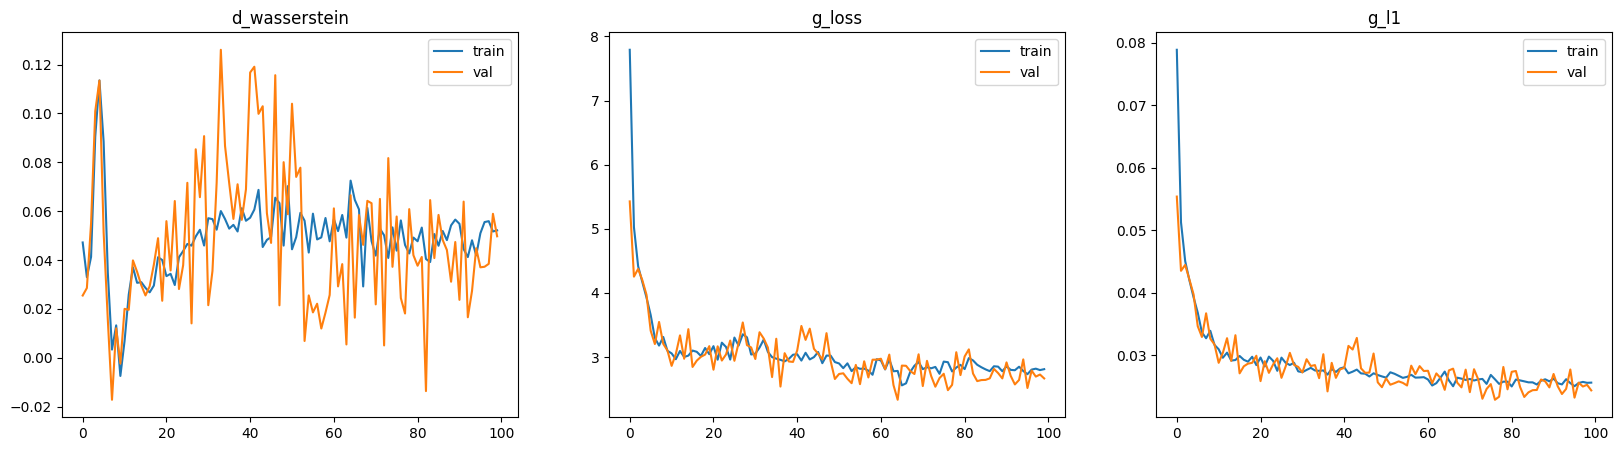

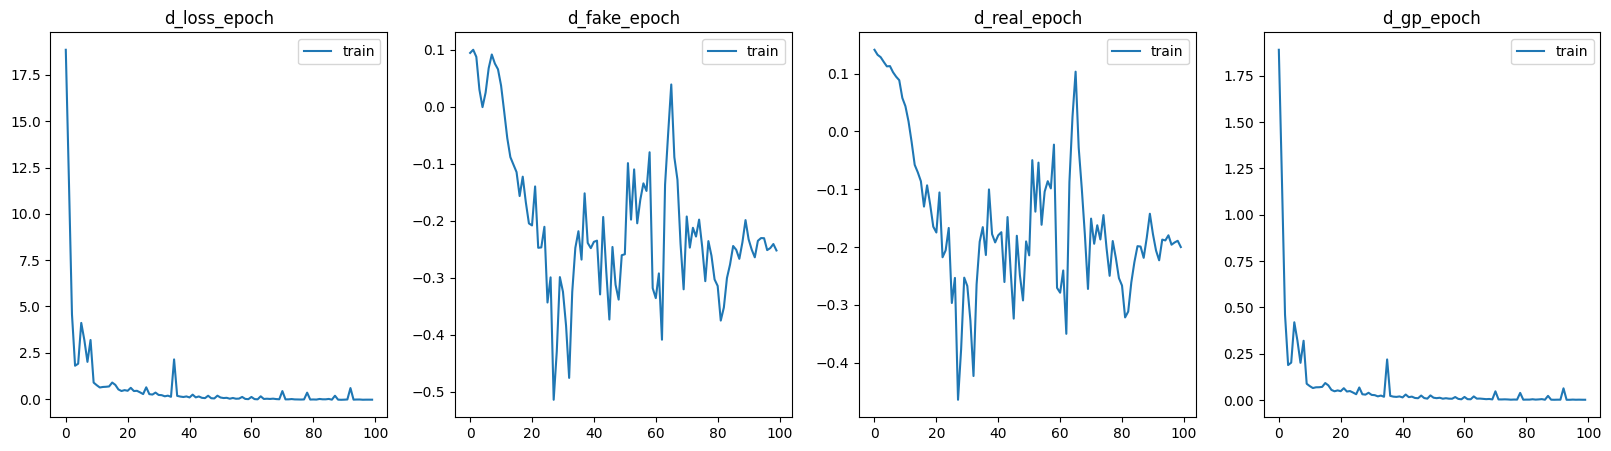

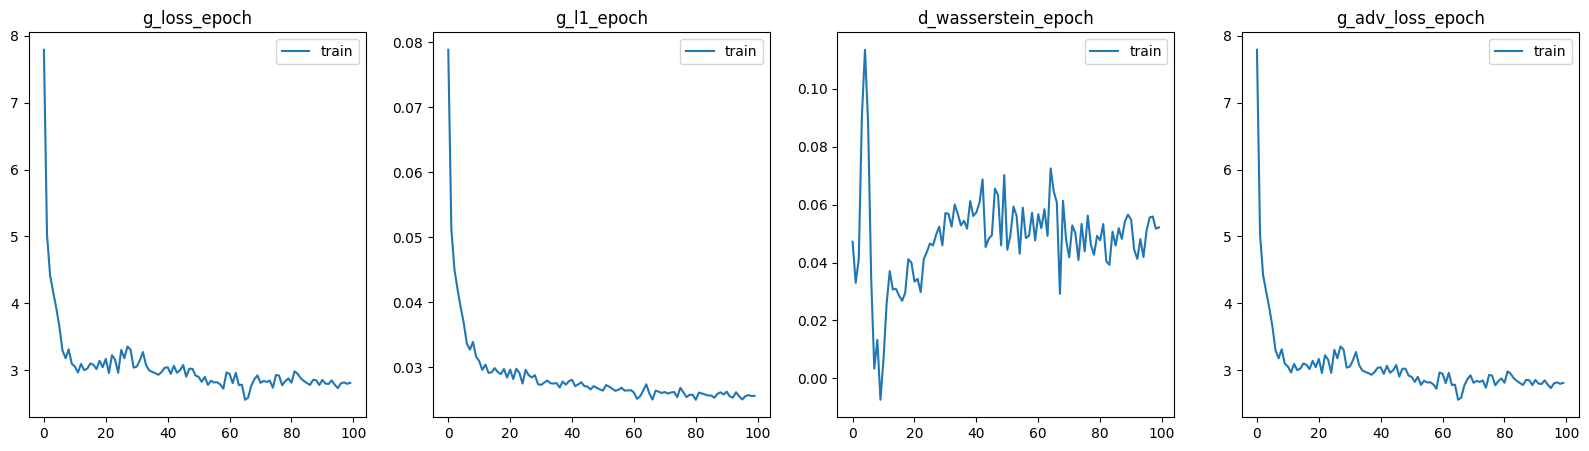

In [30]:
if config_df.model_name == 'wgan':
    metric_list = ['d_wasserstein', 'g_loss', 'g_l1']
    plt.figure(figsize=(20,5))
    for i, metric in enumerate(metric_list):
        loss = np.load(os.path.join(train_metrics_path, f'{metric}_epoch.npy'))
        val_loss = np.load(os.path.join(train_metrics_path, f'val_{metric}.npy'))

        plt.subplot(1,len(metric_list), i+1)
        sns.lineplot(x=np.arange(len(loss)), y=loss, label='train')
        sns.lineplot(x=np.arange(len(val_loss)), y=val_loss, label='val')
        plt.title(metric)
    plt.show()

    metric_list = ['d_loss_epoch', 'd_fake_epoch', 'd_real_epoch', 'd_gp_epoch']
    plt.figure(figsize=(20,5))
    for i, metric in enumerate(metric_list):
        loss = np.load(os.path.join(train_metrics_path, f'{metric}.npy'))

        plt.subplot(1,len(metric_list), i+1)
        sns.lineplot(x=np.arange(len(loss)), y=loss, label='train')
        plt.title(metric)
    plt.show()

    metric_list = ['g_loss_epoch', 'g_l1_epoch', 'd_wasserstein_epoch', 'g_adv_loss_epoch']
    plt.figure(figsize=(20,5))
    for i, metric in enumerate(metric_list):
        loss = np.load(os.path.join(train_metrics_path, f'{metric}.npy'))

        plt.subplot(1,len(metric_list), i+1)
        sns.lineplot(x=np.arange(len(loss)), y=loss, label='train')
        plt.title(metric)
    plt.show()

else:
    metric_list = ['loss', 'mean_squared_error', 'ssim_loss']

    plt.figure(figsize=(20,5))
    for i, metric in enumerate(metric_list):
        loss = np.load(os.path.join(train_metrics_path, f'{metric}.npy'))
        val_loss = np.load(os.path.join(train_metrics_path, f'val_{metric}.npy'))

        plt.subplot(1,len(metric_list), i+1)
        sns.lineplot(x=np.arange(len(loss)), y=loss, label='train')
        sns.lineplot(x=np.arange(len(val_loss)), y=val_loss, label='val')
        plt.title(metric)

    plt.show()


### Visualization of the testing information

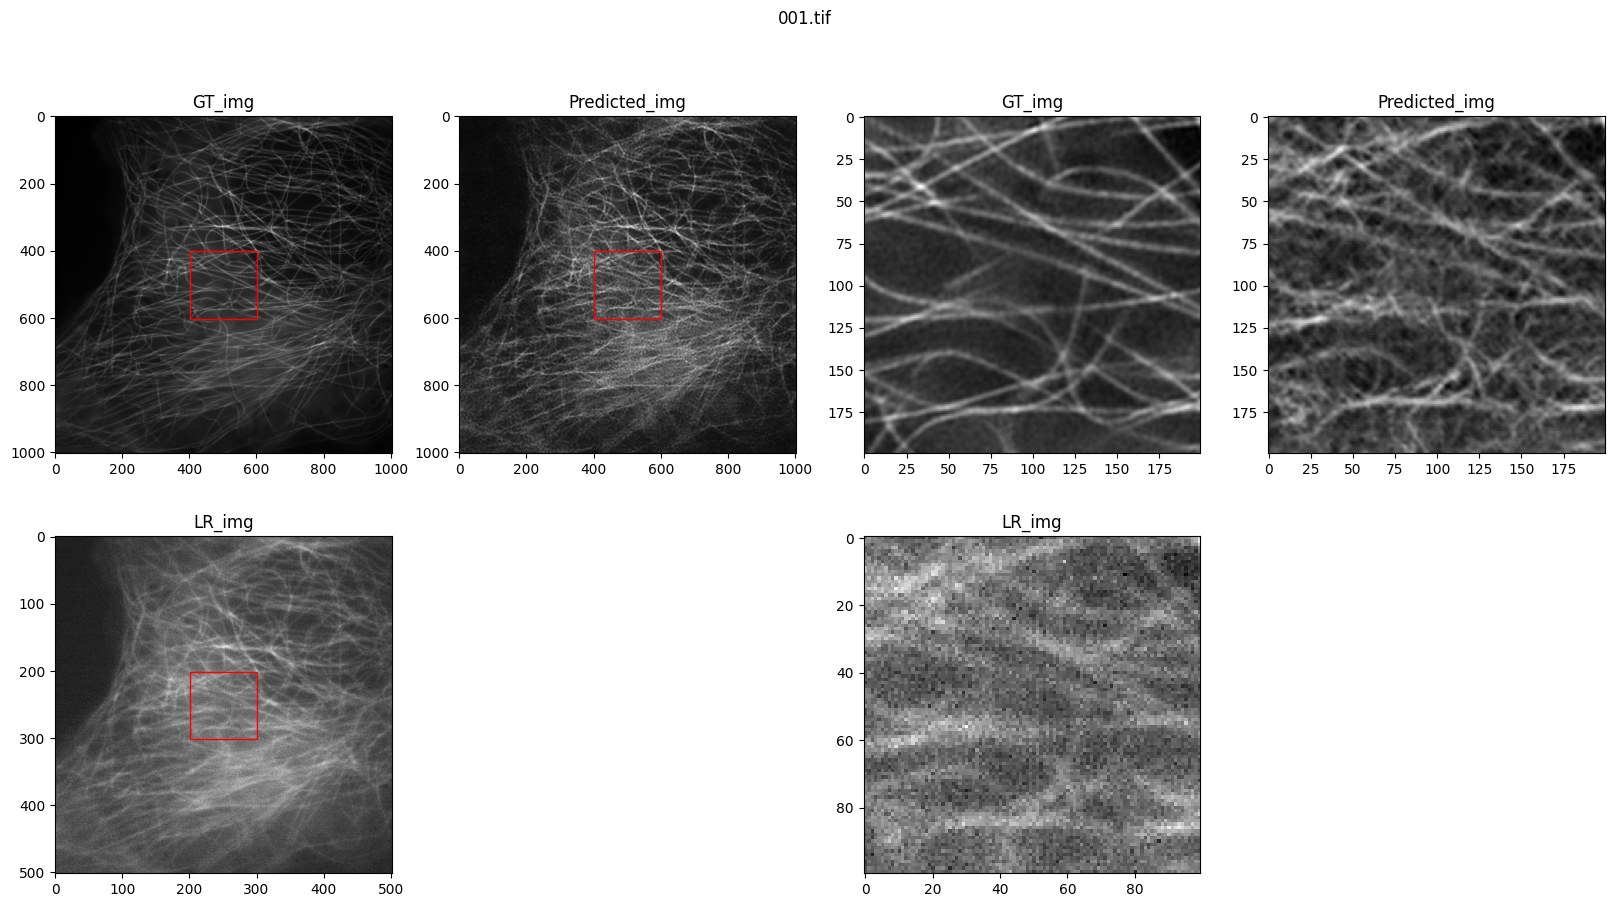

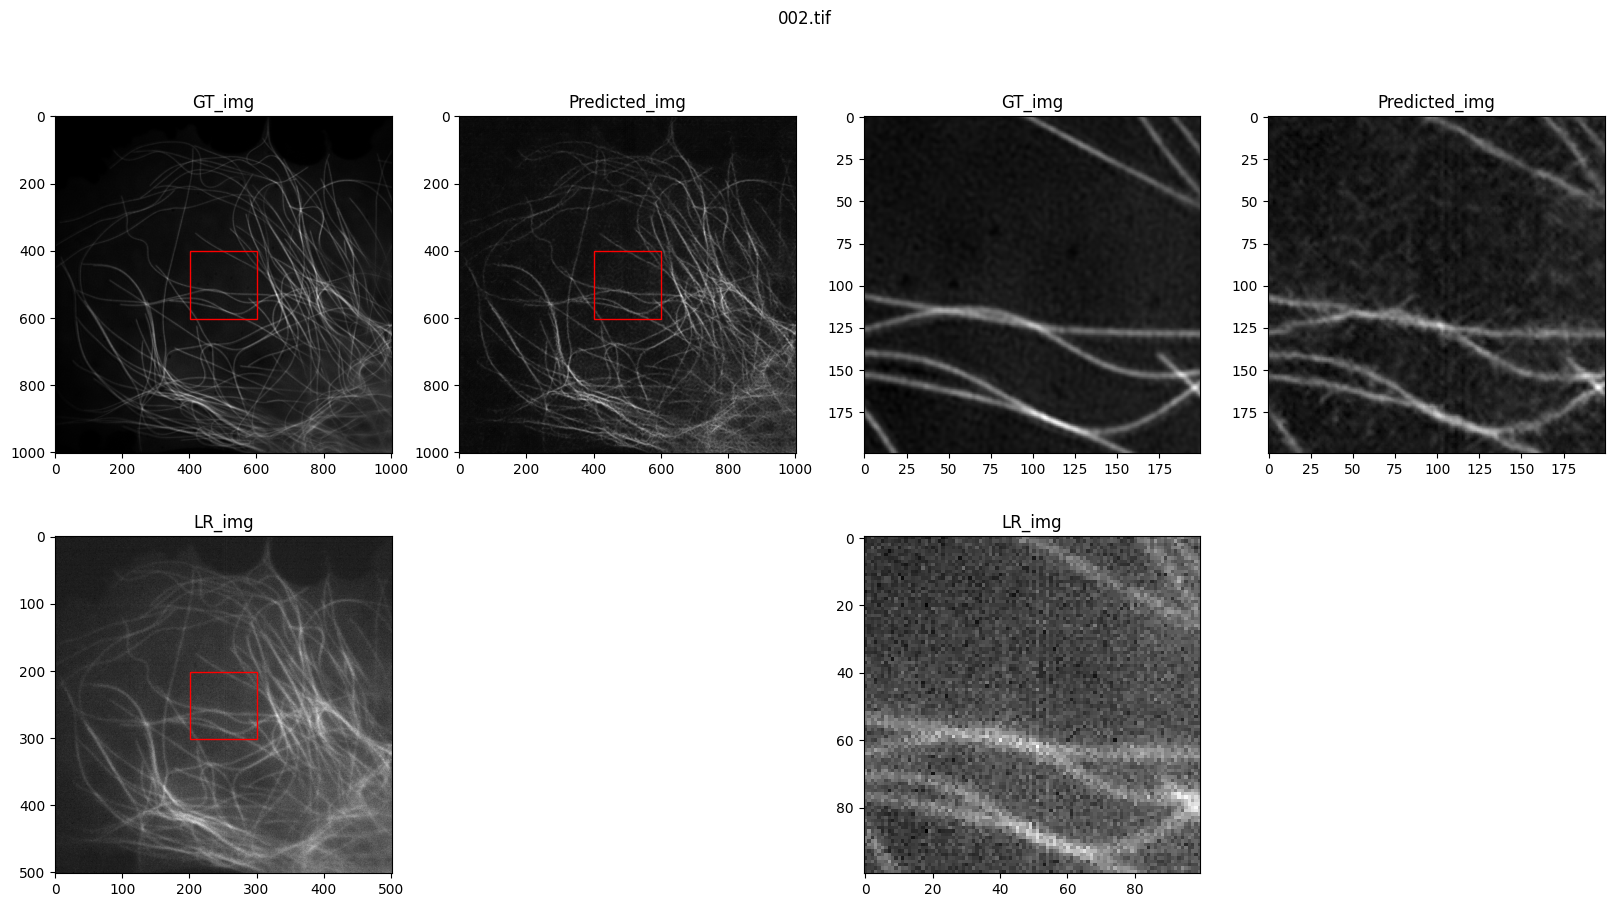

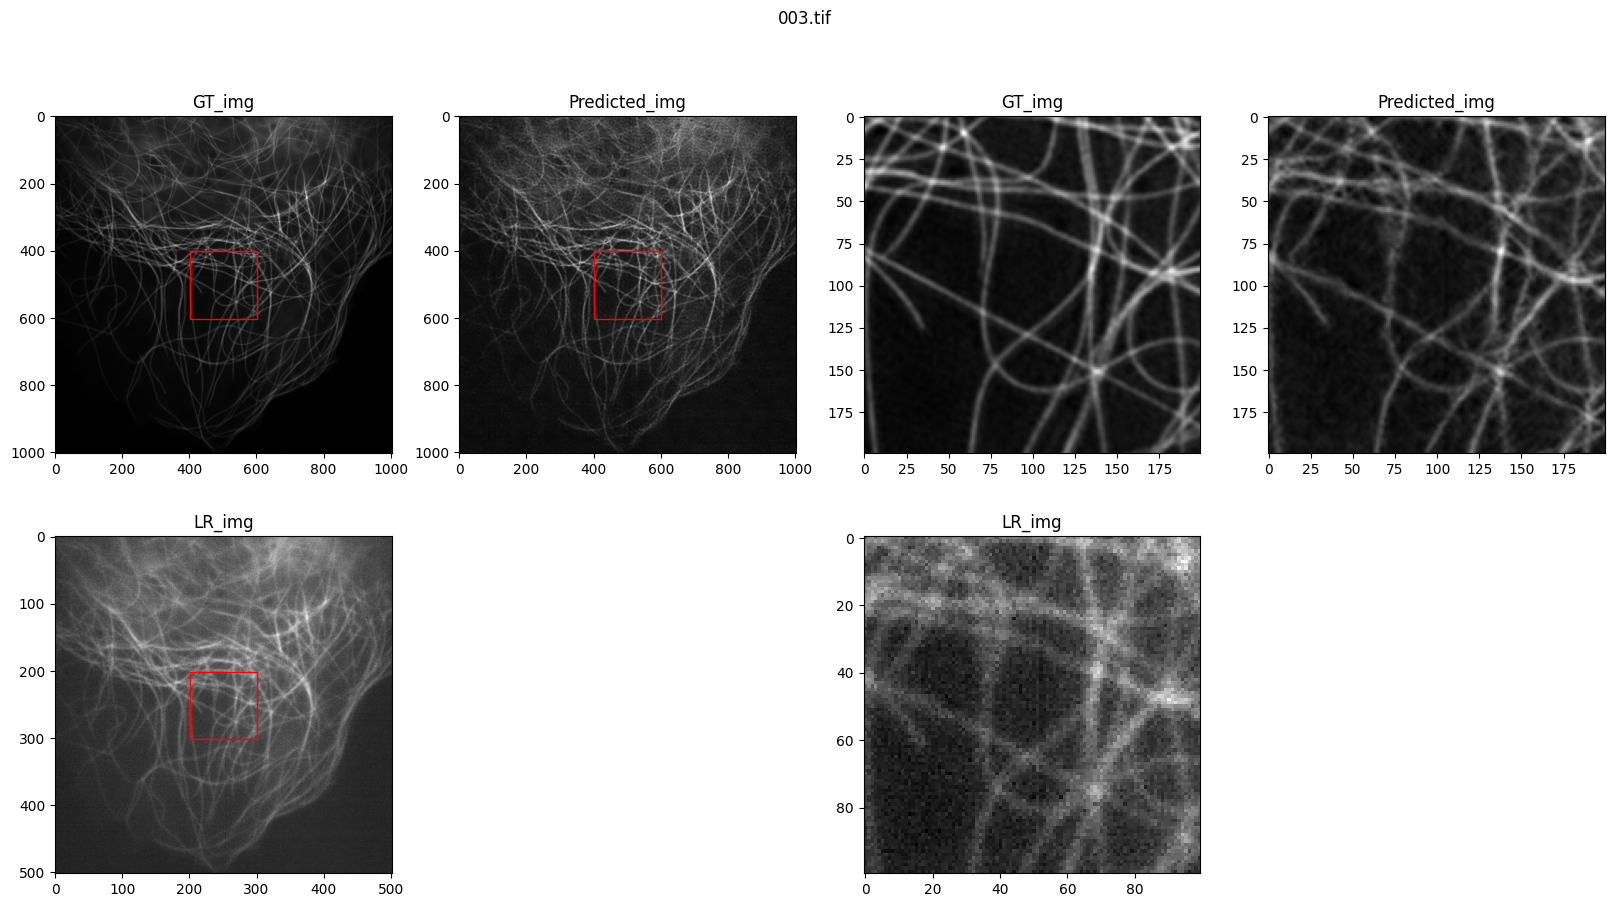

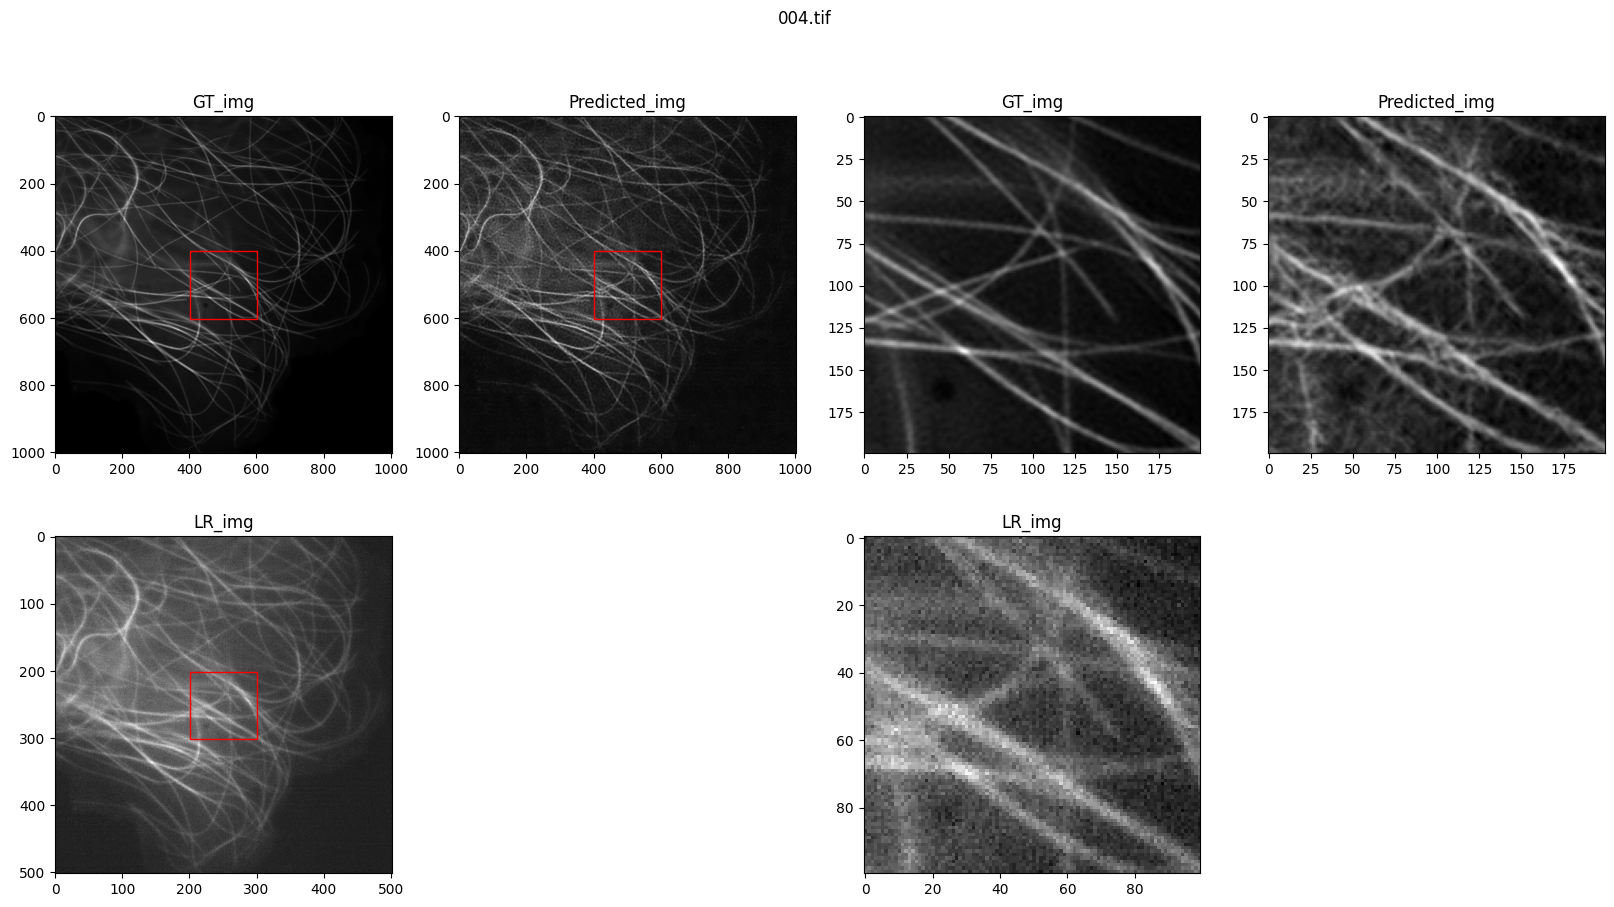

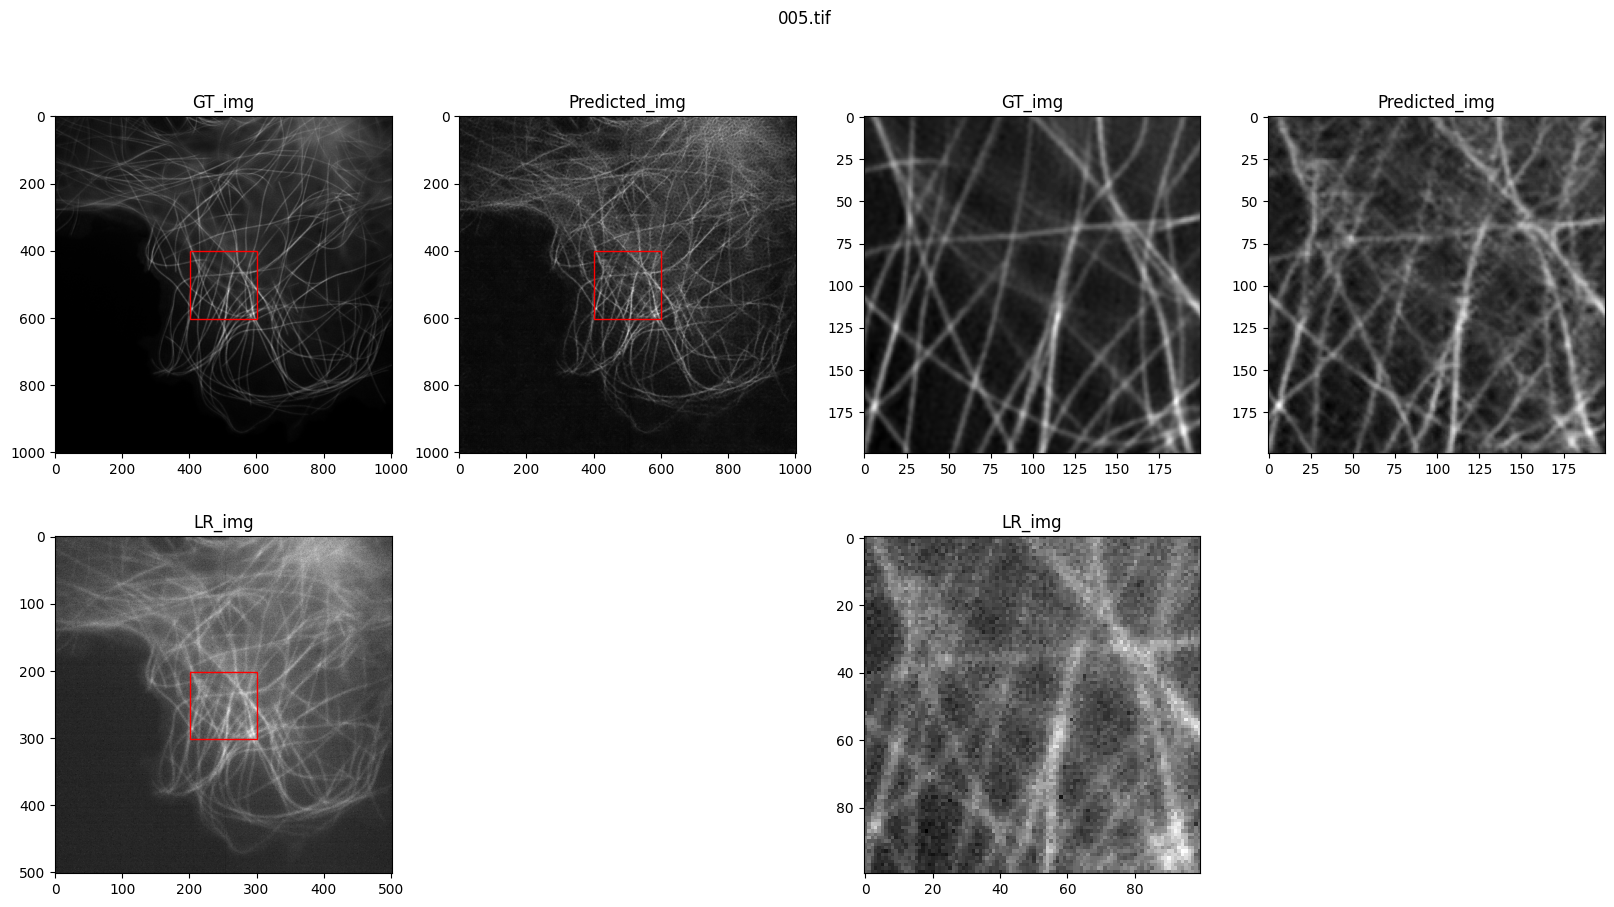

In [31]:
zoom_size = 100
center_point = None

dataset_config = utils.load_yaml('./conf/dataset/default.yaml')
dataset_root = 'datasets' if os.path.exists('datasets') else '../datasets'
dataset_name = config_df['dataset_name']
train_lr, train_hr, val_lr, val_hr, test_lr, test_hr = dataset_config[dataset_name]['data_paths']
test_lr_path = os.path.join(dataset_root, dataset_name, test_lr) if test_lr is not None else None
test_hr_path = os.path.join(dataset_root, dataset_name, test_hr) if test_hr is not None else None

for f in sorted(os.listdir(predicted_images_path))[:5]:
    img_path = os.path.join(predicted_images_path, f)
    gt_img_path = os.path.join(test_hr_path, f)
    wf_img_path = os.path.join(test_lr_path, f)

    img = io.imread(img_path)
    gt_img = io.imread(gt_img_path)
    wf_img = io.imread(wf_img_path)

    scale = gt_img.shape[0] // wf_img.shape[0]

    plt.figure(figsize=(20,10))

    gt_center_point = center_point if center_point is not None else (gt_img.shape[0]//2, gt_img.shape[1]//2)
    wt_center_point = (gt_center_point[0]//scale, gt_center_point[1]//scale)
    wf_zoom_size = zoom_size // scale

    plt.subplot(2,4,1)
    plt.imshow(gt_img, 'gray')
    plt.title('GT_img')
    ax = plt.gca()
    ax.add_patch(Rectangle((gt_center_point[0]-zoom_size, gt_center_point[1]-zoom_size),zoom_size*2,zoom_size*2,
                            linewidth=1,edgecolor='r',facecolor='none'))
    plt.subplot(2,4,2)
    plt.imshow(img, 'gray')
    plt.title('Predicted_img')
    ax = plt.gca()
    ax.add_patch(Rectangle((gt_center_point[0]-zoom_size, gt_center_point[1]-zoom_size),zoom_size*2,zoom_size*2,
                            linewidth=1,edgecolor='r',facecolor='none'))
    plt.subplot(2,4,3)
    plt.imshow(gt_img[gt_center_point[0]-zoom_size:gt_center_point[0]+zoom_size,
                      gt_center_point[1]-zoom_size:gt_center_point[1]+zoom_size], 'gray')
    plt.title('GT_img')
    plt.subplot(2,4,4)
    plt.imshow(img[gt_center_point[0]-zoom_size:gt_center_point[0]+zoom_size,
                      gt_center_point[1]-zoom_size:gt_center_point[1]+zoom_size], 'gray')
    plt.title('Predicted_img')
    plt.suptitle(f)


    plt.subplot(2,4,5)
    plt.imshow(wf_img, 'gray')
    plt.title('LR_img')
    ax = plt.gca()
    ax.add_patch(Rectangle((wt_center_point[0]-wf_zoom_size, wt_center_point[1]-wf_zoom_size),
                            wf_zoom_size*2,wf_zoom_size*2,
                            linewidth=1,edgecolor='r',facecolor='none'))
    plt.subplot(2,4,7)
    plt.imshow(wf_img[wt_center_point[0]-wf_zoom_size:wt_center_point[0]+wf_zoom_size,
                      wt_center_point[1]-wf_zoom_size:wt_center_point[1]+wf_zoom_size], 'gray')
    plt.title('LR_img')
    plt.suptitle(f)

    plt.show()

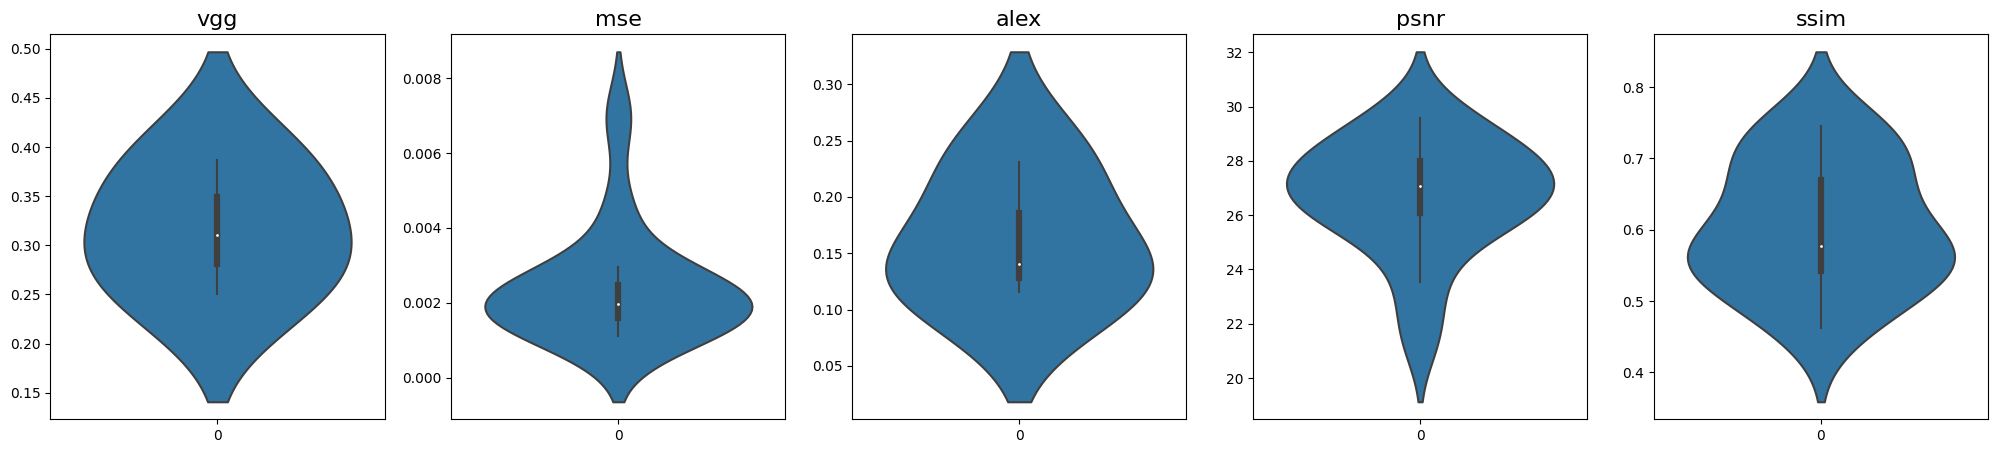

In [32]:
metric_list = [e[:-4] for e in os.listdir(test_metrics_path)]

plt.figure(figsize=(5*len(metric_list),5))
for i, metric in enumerate(metric_list):
    loss = np.load(os.path.join(test_metrics_path, f'{metric}.npy'))

    plt.subplot(1,len(metric_list), i+1)
    sns.violinplot(loss, label='train')
    plt.title(metric, fontsize=16)

plt.show()

# Analyze a group of configurations

In [16]:
df = load_dataframe()    
filtered_df = df[['dataset_name', 'model_name', 
                'batch_size', 'num_epochs', 'patience', 'validation_split', 
                'lr', 'discriminator_lr',
                'additional_folder', 'data_augmentation', 'datagen_sampling_pdf',
                'optimizer', 'discriminator_optimizer', 
                'scheduler', 'discriminator_lr_scheduler', 'seed', 
                'config_path',  
                'mse_mean', 'mse_std', 
                'psnr_mean', 'psnr_std', 
                'ssim_mean', 'ssim_std',                     
                'vgg_mean', 'vgg_std', 
                'alex_mean', 'alex_std',
                'pred_rse_mean', 'pred_rse_std',
                'gt_rse_mean', 'gt_rse_std',
                'pred_rsp_mean', 'pred_rsp_std',
                'gt_rsp_mean', 'gt_rsp_std',
                'ilniqe_mean', 'ilniqe_std',
                'decor_mean', 'decor_std',
                ]].copy()

desired_dataset = "F-actin" # 'LiveFActinDataset', 'EM', 'MitoTracker_small', 'F-actin', 'ER', 'MT', 'MT-SMLM_all'
desired_model = 'unet' # "unet", "rcan", "dfcan", "wdsr", "wgan", "esrganplus", "cddpm"

max_epochs = 101 # np.Inf
min_epochs = 100 # np.Inf

if desired_dataset is not None:
    filtered_df = filtered_df[filtered_df['dataset_name'] == desired_dataset]

if desired_model is not None:
    filtered_df = filtered_df[filtered_df['model_name'] == desired_model]

filtered_df = filtered_df[filtered_df['num_epochs'] < max_epochs]
filtered_df = filtered_df[filtered_df['num_epochs'] >= min_epochs]

filtered_df.sort_values(by=['ssim_mean'], ascending=False)

dataset_name model_name batch_size num_epochs patience  \
unet_F-actin_97       F-actin       unet          8        100      100   
unet_F-actin_107      F-actin       unet          4        100      100   
unet_F-actin_15       F-actin       unet          8        100      100   
unet_F-actin_109      F-actin       unet          8        100      100   
unet_F-actin_100      F-actin       unet          8        100      100   
unet_F-actin_35       F-actin       unet          8        100      100   
unet_F-actin_5        F-actin       unet          8        100      100   
unet_F-actin_84       F-actin       unet          8        100      100   
unet_F-actin_52       F-actin       unet          8        100      100   
unet_F-actin_55       F-actin       unet          8        100      100   
unet_F-actin_103      F-actin       unet          8        100      100   
unet_F-actin_10       F-actin       unet          8        100      100   
unet_F-actin_92       F-actin       unet          8        100      100   
unet_F-actin_72       F-actin       unet          8        100      100   
unet_F-actin_86       F-actin       unet          8        100      100   
unet_F-actin_17       F-actin       unet          8        100      100   
unet_F-actin_65       F-actin       unet          8        100      100   
unet_F-actin_60       F-actin       unet          8        100      100   
unet_F-actin_48       F-actin       unet          8        100      100   
unet_F-actin_51       F-actin       unet          8        100      100   
unet_F-actin_9        F-actin       unet          8        100      100   
unet_F-actin_82       F-actin       unet          8        100      100   
unet_F-actin_14       F-actin       unet          8        100      100   
unet_F-actin_68       F-actin       unet          8        100      100   
unet_F-actin_63       F-actin       unet          8        100      100   
unet_F-actin_56       F-actin       unet          8        100      100   
unet_F-actin_69       F-actin       unet          8        100      100   
unet_F-actin_85       F-actin       unet          8        100      100   
unet_F-actin_24       F-actin       unet          8        100      100   
unet_F-actin_47       F-actin       unet          8        100      100   
unet_F-actin_25       F-actin       unet          8        100      100   
unet_F-actin_21       F-actin       unet          8        100      100   
unet_F-actin_16       F-actin       unet          8        100      100   
unet_F-actin_102      F-actin       unet          8        100      100   
unet_F-actin_95       F-actin       unet          8        100      100   
unet_F-actin_6        F-actin       unet          8        100      100   
unet_F-actin_58       F-actin       unet          8        100      100   
unet_F-actin_67       F-actin       unet          8        100      100   
unet_F-actin_78       F-actin       unet          8        100      100   
unet_F-actin_106      F-actin       unet          8        100      100   
unet_F-actin_91       F-actin       unet          8        100      100   
unet_F-actin_71       F-actin       unet         16        100      100   
unet_F-actin_29       F-actin       unet          8        100      100   
unet_F-actin_36       F-actin       unet          8        100      100   
unet_F-actin_22       F-actin       unet          8        100      100   
unet_F-actin_64       F-actin       unet          8        100      100   
unet_F-actin_62       F-actin       unet          8        100      100   
unet_F-actin_66       F-actin       unet          8        100      100   
unet_F-actin_83       F-actin       unet          8        100      100   
unet_F-actin_108      F-actin       unet          8        100      100   
unet_F-actin_70       F-actin       unet          8        100      100   
unet_F-actin_37       F-actin       unet          8        100      100   
unet_F-actin_40       F-actin       unet  

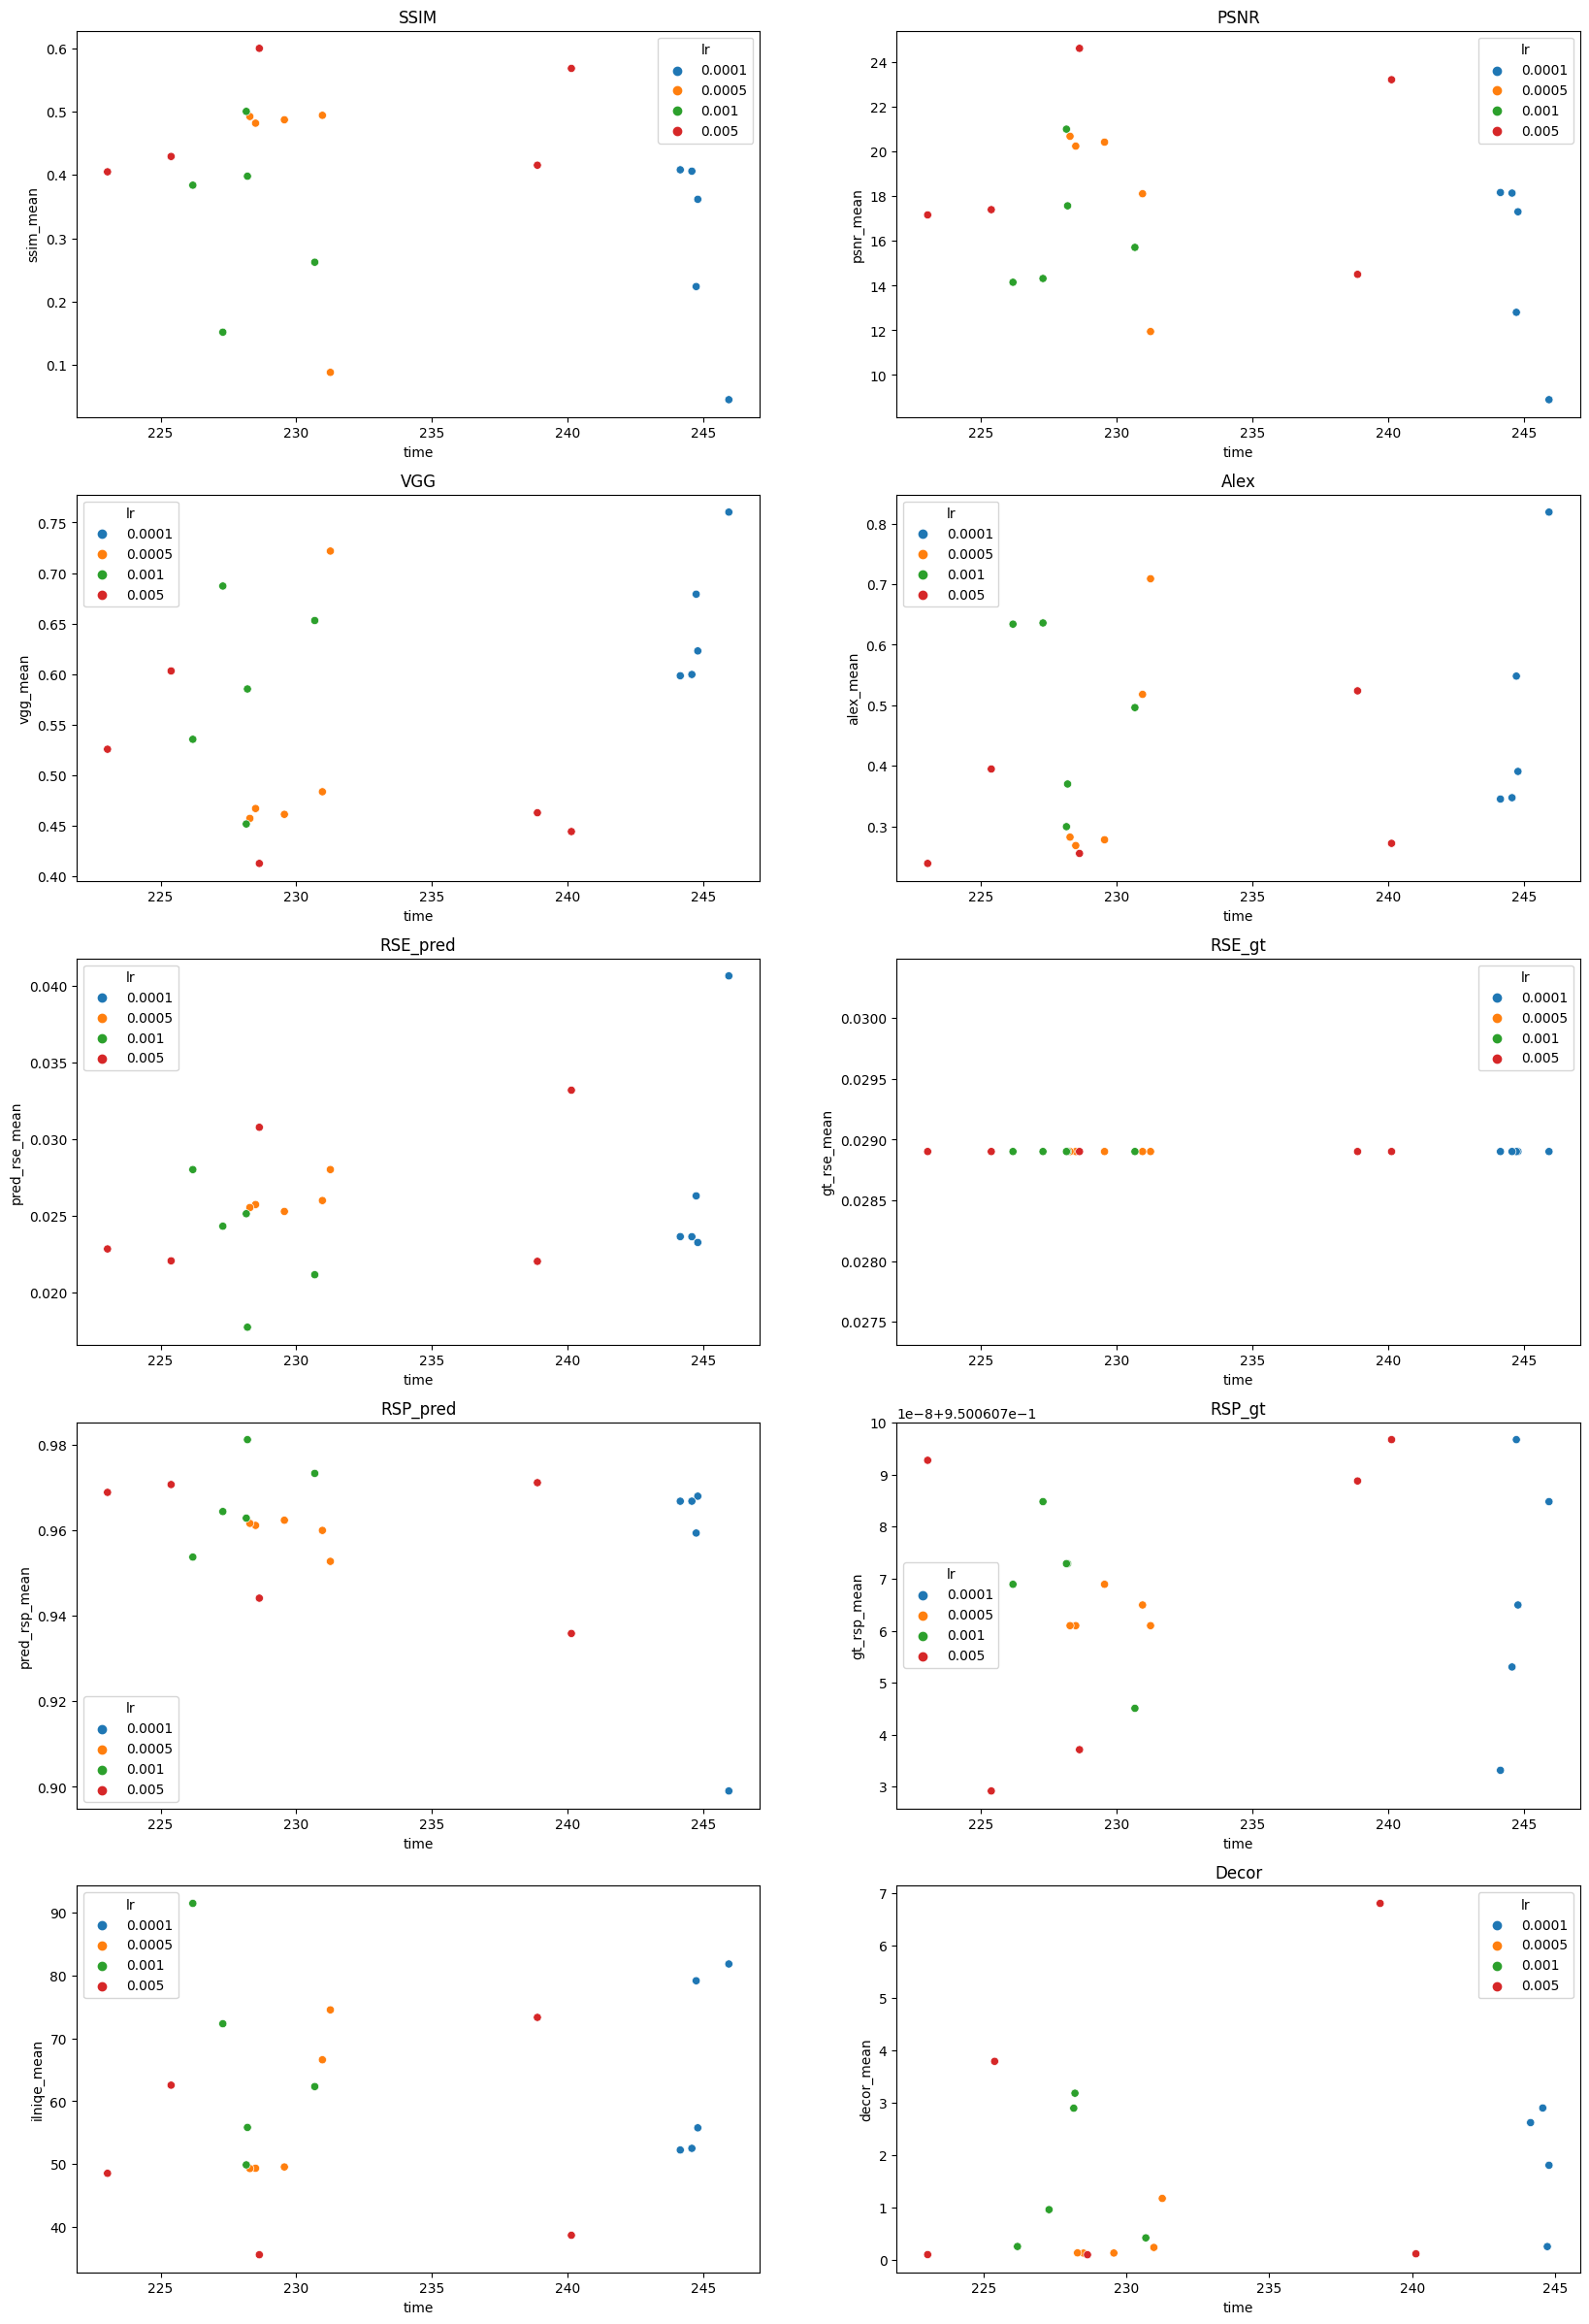

In [17]:
test_metrics = {}

for name, conf_path in zip(filtered_df.index, filtered_df['config_path']):

    test_metrics_path = os.path.join(conf_path, 'test_metrics')

    metric_dict = {}
    
    for metric_file in os.listdir(test_metrics_path):
        metric_dict[metric_file[:-4]] = np.load(os.path.join(test_metrics_path, metric_file))

    metric_dict['time'] = np.load(os.path.join(conf_path, 'train_metrics', 'time.npy'))[0]

    test_metrics[name] = metric_dict

test_metrics_df = pd.DataFrame(test_metrics).T

simple_test_metrics_df = filtered_df[['vgg_mean', 'vgg_std', 
                                     'mse_mean', 'mse_std', 
                                     'alex_mean', 'alex_std',
                                     'psnr_mean', 'psnr_std',
                                     'ssim_mean', 'ssim_std',         
                                     'pred_rse_mean', 'pred_rse_std',
                                     'gt_rse_mean', 'gt_rse_std',
                                     'pred_rsp_mean', 'pred_rsp_std',
                                     'gt_rsp_mean', 'gt_rsp_std',
                                     'ilniqe_mean', 'ilniqe_std',
                                     'optimizer', 'discriminator_optimizer', 
                                     'scheduler', 'discriminator_lr_scheduler', 'seed', 
                                     'decor_mean', 'decor_std', 'lr']].copy()
simple_test_metrics_df = simple_test_metrics_df.join(test_metrics_df['time']/60)
simple_test_metrics_df = simple_test_metrics_df.join(filtered_df['model_name'])
simple_test_metrics_df.sort_values(by=['vgg_mean'])#, ascending=False)

fig, axes = plt.subplots(5,2, figsize=(20,30))

simple_test_metrics_df = simple_test_metrics_df[simple_test_metrics_df['scheduler'] == 'ReduceOnPlateau']

axes[0,0].set_title('SSIM')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[0,0], y='ssim_mean', x='time', hue='lr', palette="tab10")
axes[0,1].set_title('PSNR')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[0,1], y='psnr_mean', x='time', hue='lr', palette="tab10")
axes[1,0].set_title('VGG')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[1,0], y='vgg_mean', x='time', hue='lr', palette="tab10")
axes[1,1].set_title('Alex')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[1,1], y='alex_mean', x='time', hue='lr', palette="tab10")

axes[2,0].set_title('RSE_pred')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[2,0], y='pred_rse_mean', x='time', hue='lr', palette="tab10")
axes[2,1].set_title('RSE_gt')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[2,1], y='gt_rse_mean', x='time', hue='lr', palette="tab10")
axes[3,0].set_title('RSP_pred')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[3,0], y='pred_rsp_mean', x='time', hue='lr', palette="tab10")
axes[3,1].set_title('RSP_gt')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[3,1], y='gt_rsp_mean', x='time', hue='lr', palette="tab10")
axes[4,1].set_title('ILNIQE')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[4,0], y='ilniqe_mean', x='time', hue='lr', palette="tab10")
axes[4,1].set_title('Decor')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[4,1], y='decor_mean', x='time', hue='lr', palette="tab10");

<Axes: title={'center': 'Alex'}, xlabel='time', ylabel='alex_mean'>

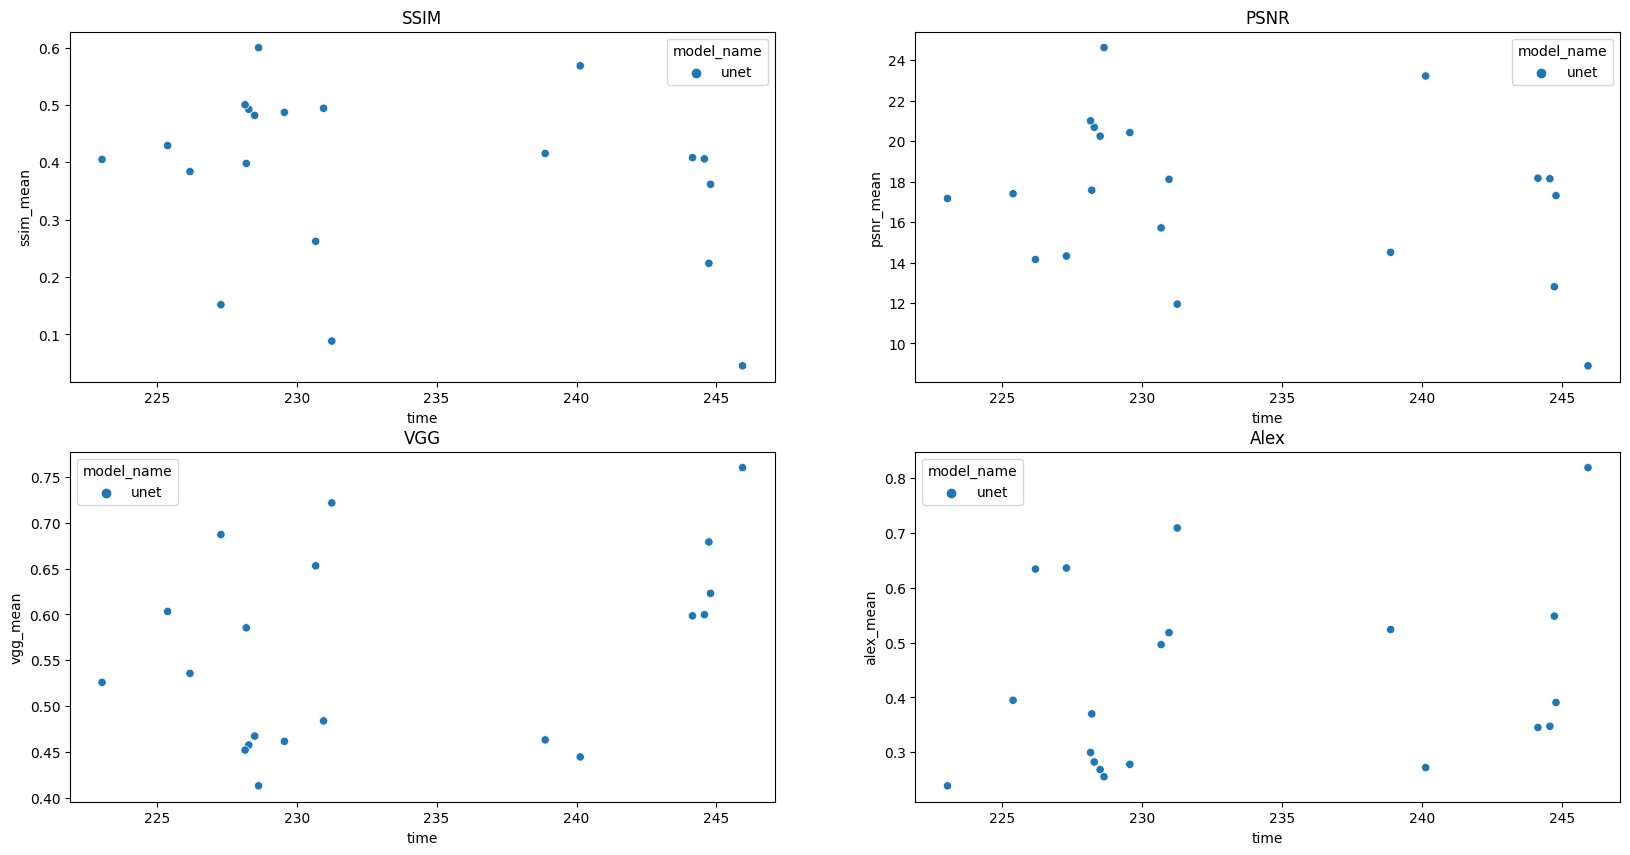

In [18]:
fig, axes = plt.subplots(2,2, figsize=(20,10))

axes[0,0].set_title('SSIM')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[0,0], y='ssim_mean', x='time', hue='model_name')
axes[0,1].set_title('PSNR')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[0,1], y='psnr_mean', x='time', hue='model_name')
axes[1,0].set_title('VGG')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[1,0], y='vgg_mean', x='time', hue='model_name')
axes[1,1].set_title('Alex')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[1,1], y='alex_mean', x='time', hue='model_name')

<Axes: title={'center': 'Decor'}>

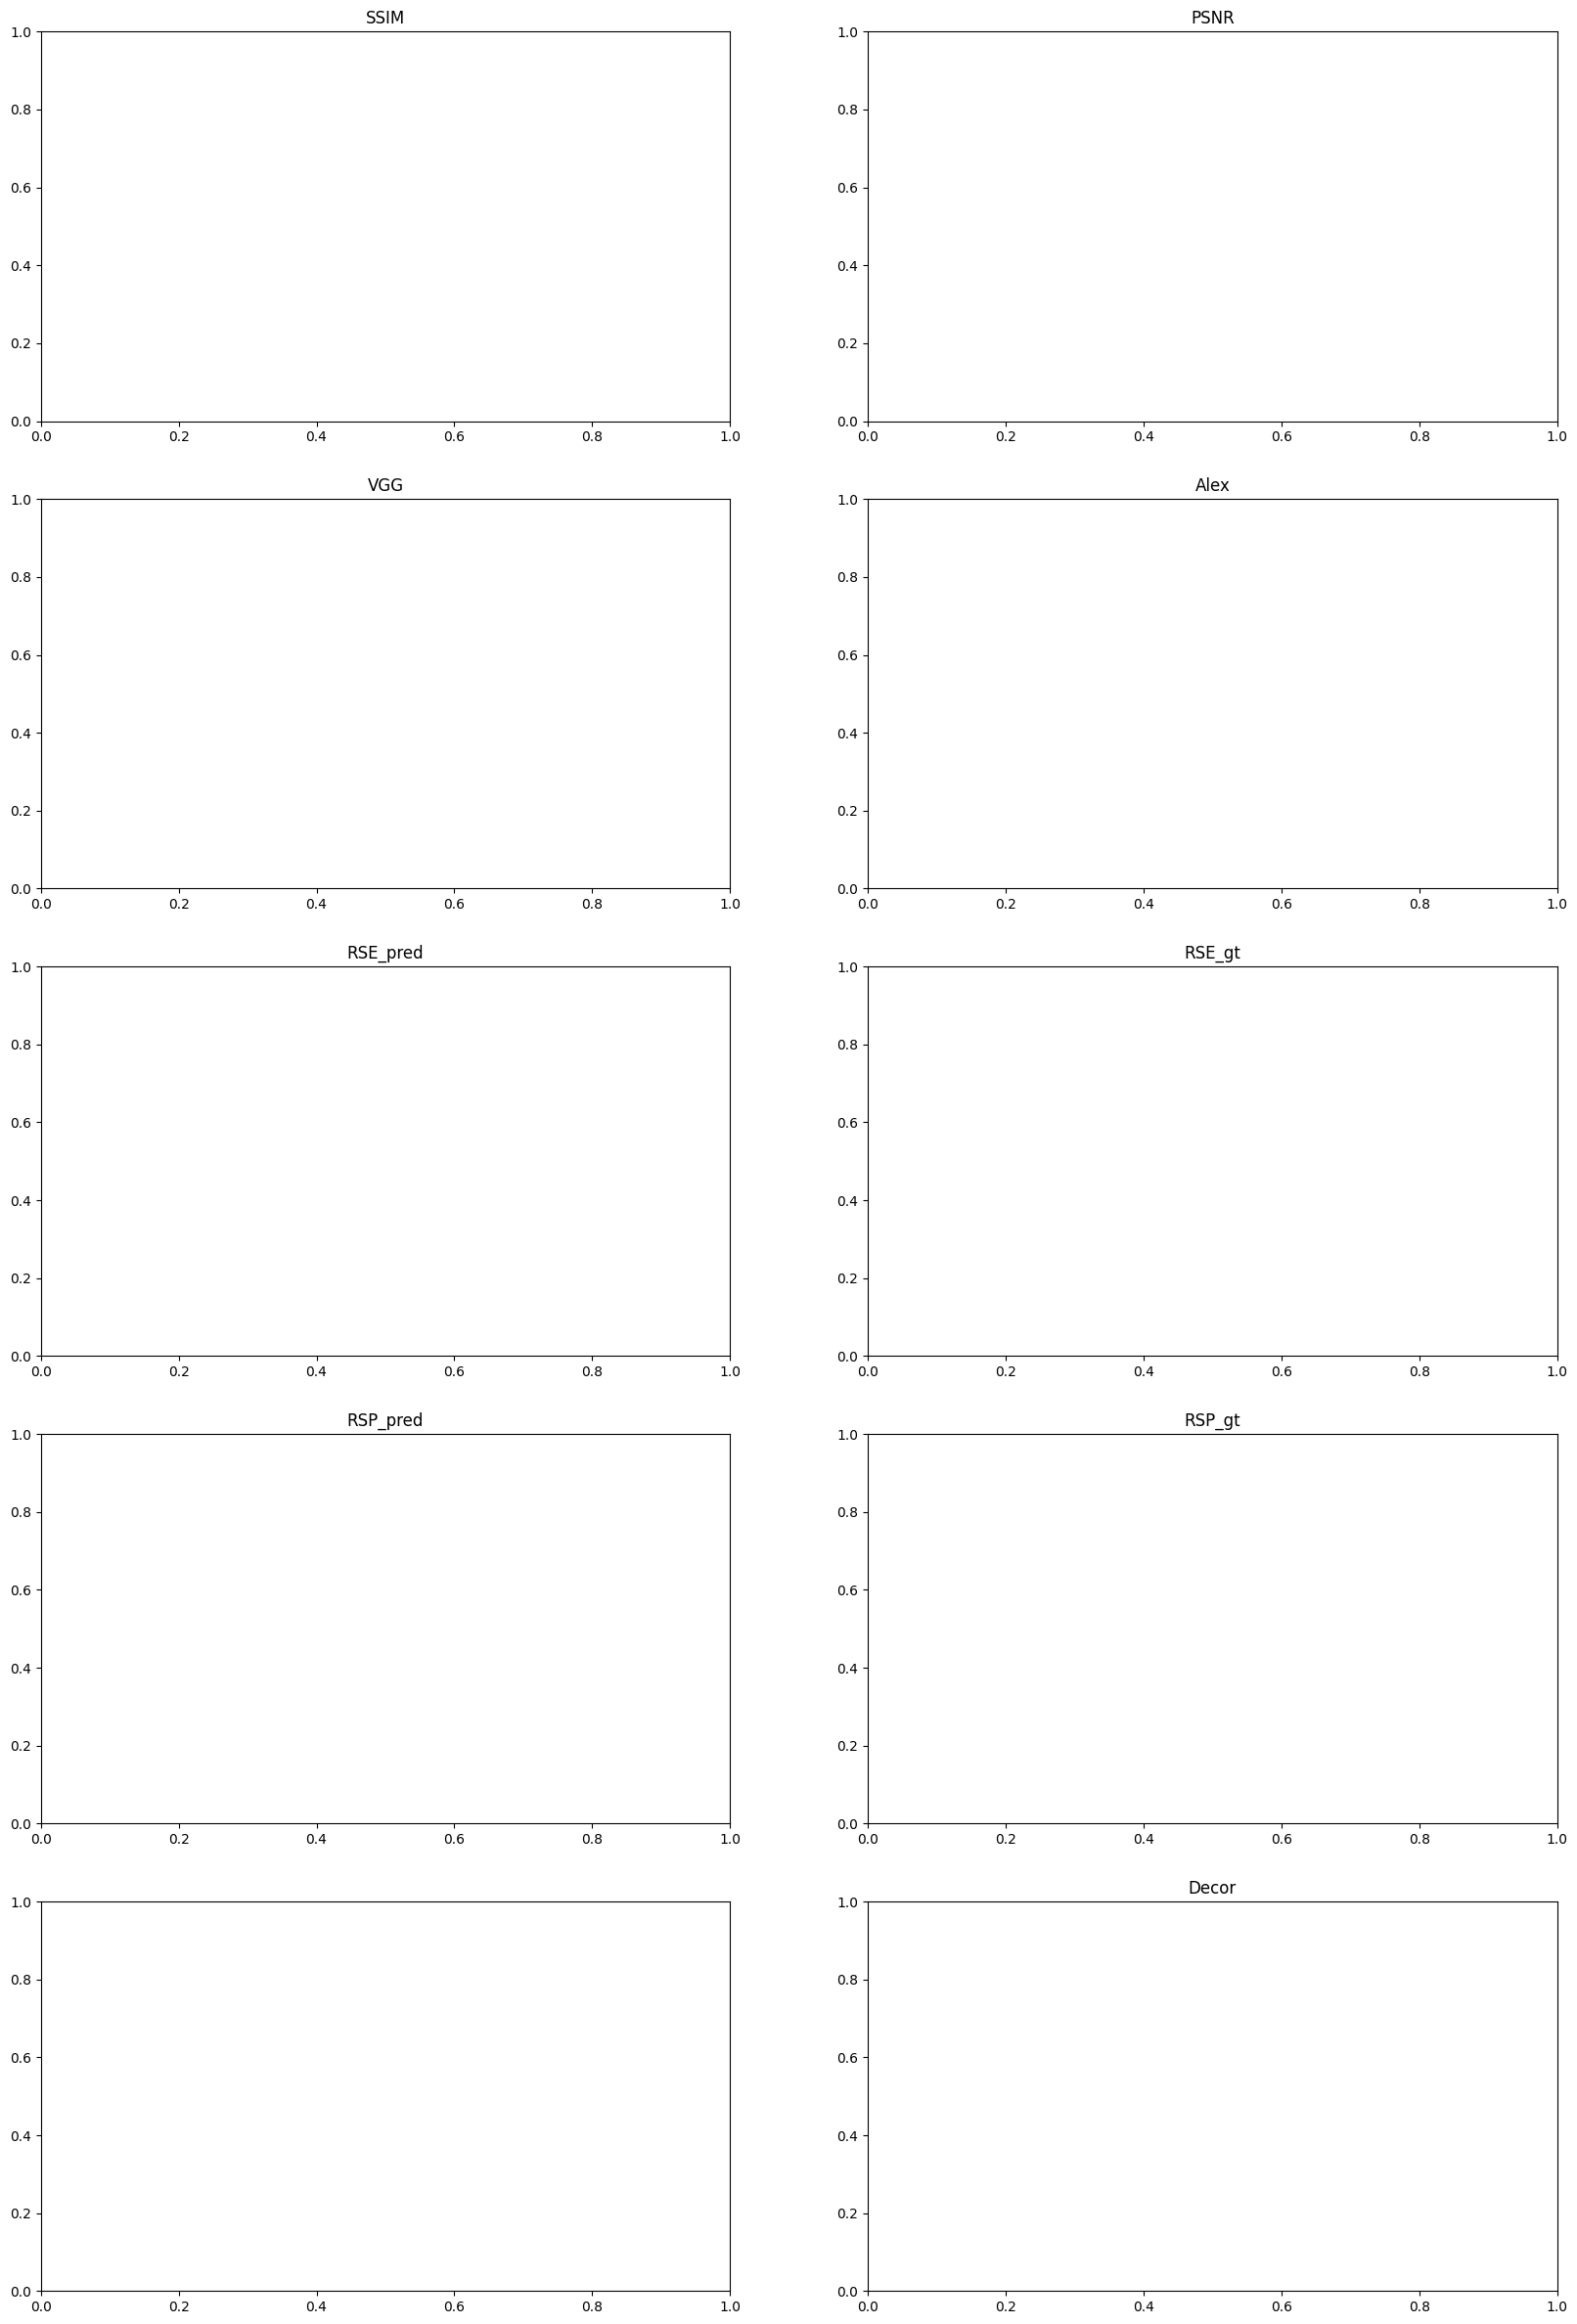

In [19]:
fig, axes = plt.subplots(5,2, figsize=(20,30))

simple_test_metrics_df = simple_test_metrics_df[simple_test_metrics_df['optimizer'] == 'OneCycle']

axes[0,0].set_title('SSIM')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[0,0], y='ssim_mean', x='time', hue='lr', palette="tab10")
axes[0,1].set_title('PSNR')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[0,1], y='psnr_mean', x='time', hue='lr', palette="tab10")
axes[1,0].set_title('VGG')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[1,0], y='vgg_mean', x='time', hue='lr', palette="tab10")
axes[1,1].set_title('Alex')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[1,1], y='alex_mean', x='time', hue='lr', palette="tab10")

axes[2,0].set_title('RSE_pred')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[2,0], y='pred_rse_mean', x='time', hue='lr', palette="tab10")
axes[2,1].set_title('RSE_gt')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[2,1], y='gt_rse_mean', x='time', hue='lr', palette="tab10")
axes[3,0].set_title('RSP_pred')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[3,0], y='pred_rsp_mean', x='time', hue='lr', palette="tab10")
axes[3,1].set_title('RSP_gt')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[3,1], y='gt_rsp_mean', x='time', hue='lr', palette="tab10")
axes[4,1].set_title('ILNIQE')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[4,0], y='ilniqe_mean', x='time', hue='lr', palette="tab10")
axes[4,1].set_title('Decor')
sns.scatterplot(data=simple_test_metrics_df, ax=axes[4,1], y='decor_mean', x='time', hue='lr', palette="tab10")

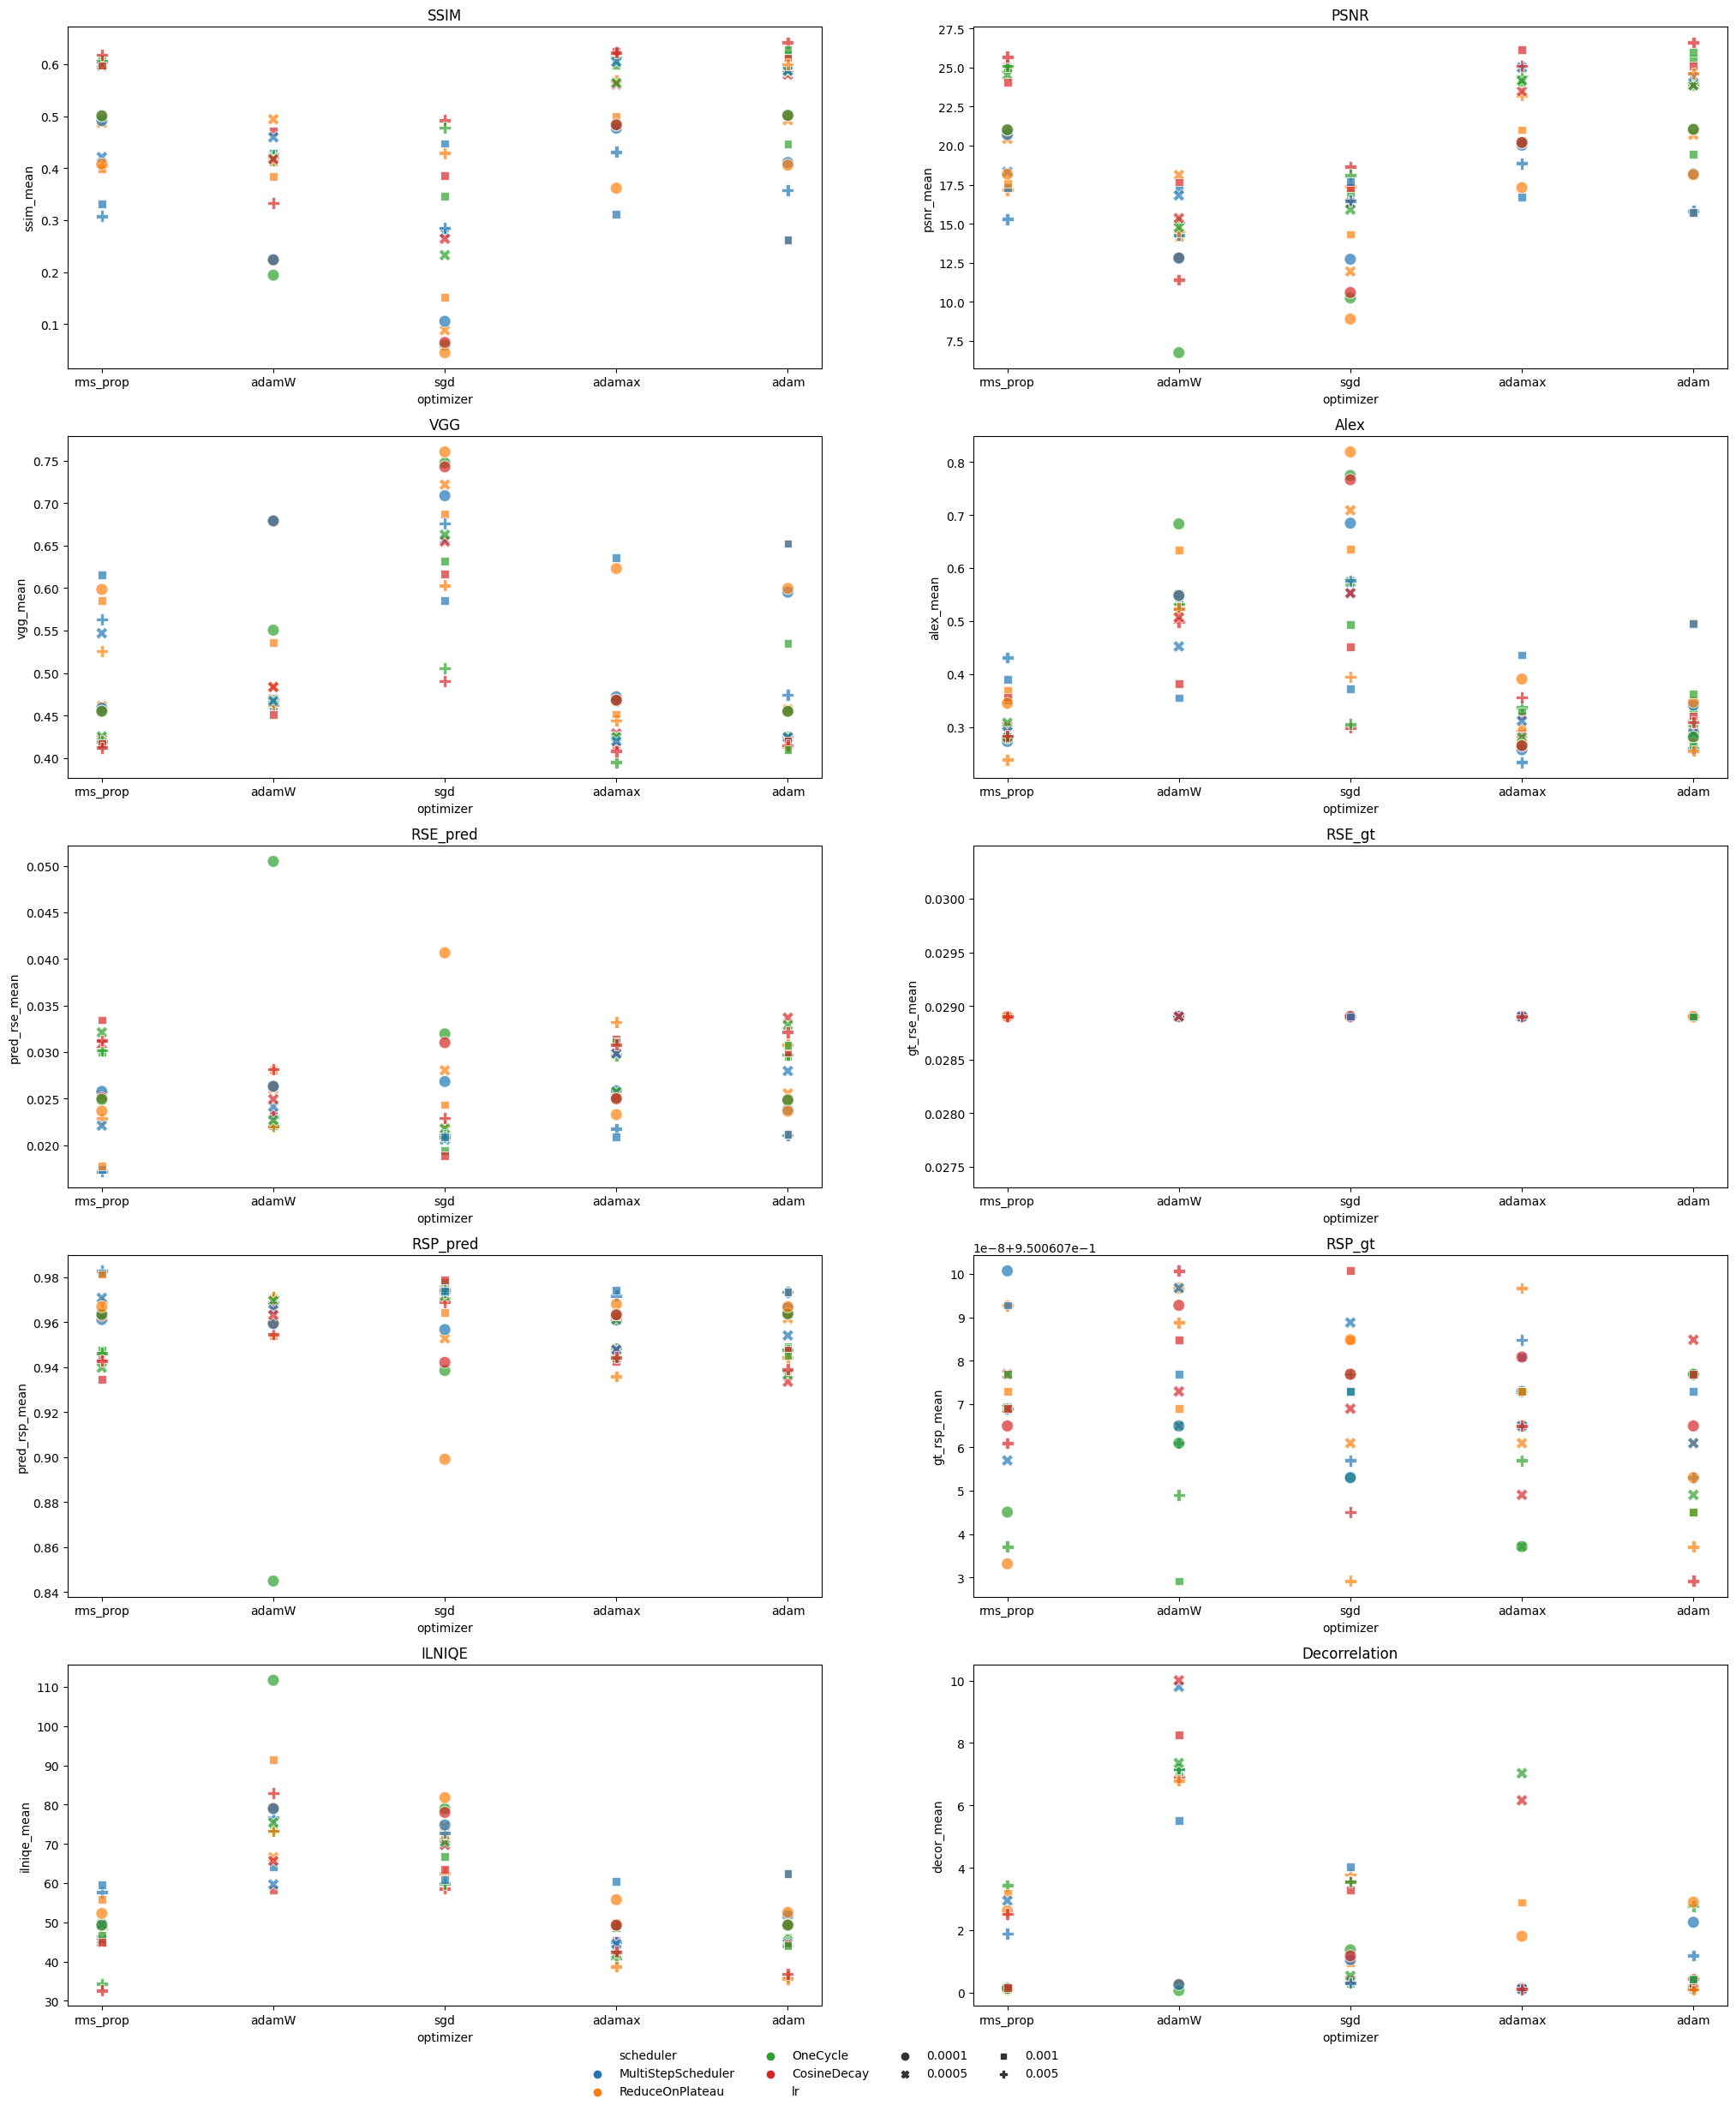

In [20]:
fig, axes = plt.subplots(5,2, figsize=(25,30))
axes[0,0].set_title('SSIM')
#axes[0,0].set_ylim((np.mean(filtered_df.loc[:, 'ssim_mean']), np.max(filtered_df.loc[:, 'ssim_mean']) + 0.05))
sns.scatterplot(data=filtered_df, ax=axes[0,0], y='ssim_mean', x='optimizer', s=100,
                hue='scheduler', style='lr', sizes=(40, 100), alpha=0.7, legend=False)

axes[0,1].set_title('PSNR')
#axes[0,1].set_ylim((np.mean(filtered_df.loc[:, 'psnr_mean']), np.max(filtered_df.loc[:, 'psnr_mean']) + 1))
sns.scatterplot(data=filtered_df, ax=axes[0,1], y='psnr_mean', x='optimizer',  s=100,
                hue='scheduler', style='lr', sizes=(40, 100), alpha=0.7, legend=False)

axes[1,0].set_title('VGG')
#axes[1,0].set_ylim((np.min(filtered_df.loc[:, 'vgg_mean']) - 0.05, np.mean(filtered_df.loc[:, 'vgg_mean'])))
sns.scatterplot(data=filtered_df, ax=axes[1,0], y='vgg_mean', x='optimizer', s=100,
                hue='scheduler', style='lr', sizes=(40, 100), alpha=0.7, legend=False)

axes[1,1].set_title('Alex')
#axes[1,1].set_ylim((np.min(filtered_df.loc[:, 'alex_mean']) - 0.05, np.mean(filtered_df.loc[:, 'alex_mean'])))
sns.scatterplot(data=filtered_df, ax=axes[1,1], y='alex_mean', x='optimizer', s=100,
                hue='scheduler', style='lr', alpha=0.7, legend=False)


axes[2,0].set_title('RSE_pred')
#axes[2,0].set_ylim((np.min(filtered_df.loc[:, 'gt_rse_mean']) - 0.05, np.mean(filtered_df.loc[:, 'gt_rse_mean'])))
sns.scatterplot(data=filtered_df, ax=axes[2,0], y='pred_rse_mean', x='optimizer', s=100,
                hue='scheduler', style='lr', sizes=(40, 100), alpha=0.7, legend=False)

axes[2,1].set_title('RSE_gt')
#axes[2,1].set_ylim((np.min(filtered_df.loc[:, 'alex_mean']) - 0.05, np.mean(filtered_df.loc[:, 'alex_mean'])))
sns.scatterplot(data=filtered_df, ax=axes[2,1], y='gt_rse_mean', x='optimizer', s=100,
                hue='scheduler', style='lr', alpha=0.7, legend=False)

axes[3,0].set_title('RSP_pred')
#axes[3,0].set_ylim((np.min(filtered_df.loc[:, 'pred_rsp_mean']) - 0.05, np.mean(filtered_df.loc[:, 'pred_rsp_mean'])))
sns.scatterplot(data=filtered_df, ax=axes[3,0], y='pred_rsp_mean', x='optimizer', s=100,
                hue='scheduler', style='lr', sizes=(40, 100), alpha=0.7, legend=False)

axes[3,1].set_title('RSP_gt')
#axes[3,1].set_ylim((np.min(filtered_df.loc[:, 'gt_rsp_mean']) - 0.05, np.mean(filtered_df.loc[:, 'gt_rsp_mean'])))
sns.scatterplot(data=filtered_df, ax=axes[3,1], y='gt_rsp_mean', x='optimizer', s=100,
                hue='scheduler', style='lr', alpha=0.7, legend=False)

axes[4,0].set_title('ILNIQE')
#axes[4,0].set_ylim((np.min(filtered_df.loc[:, 'ilniqe_mean']) - 0.05, np.mean(filtered_df.loc[:, 'ilniqe_mean'])))
sns.scatterplot(data=filtered_df, ax=axes[4,0], y='ilniqe_mean', x='optimizer', s=100,
                hue='scheduler', style='lr', sizes=(40, 100), alpha=0.7, legend=False)

axes[4,1].set_title('Decorrelation')
#axes[4,1].set_ylim((np.min(filtered_df.loc[:, 'decor_mean']) - 0.05, np.mean(filtered_df.loc[:, 'decor_mean'])))
sns.scatterplot(data=filtered_df, ax=axes[4,1], y='decor_mean', x='optimizer', s=100,
                hue='scheduler', style='lr', alpha=0.7)
sns.move_legend(
    axes[4,1], "lower center",
    bbox_to_anchor=(-0.2, -0.3), ncol=4, title=None, frameon=False,
)

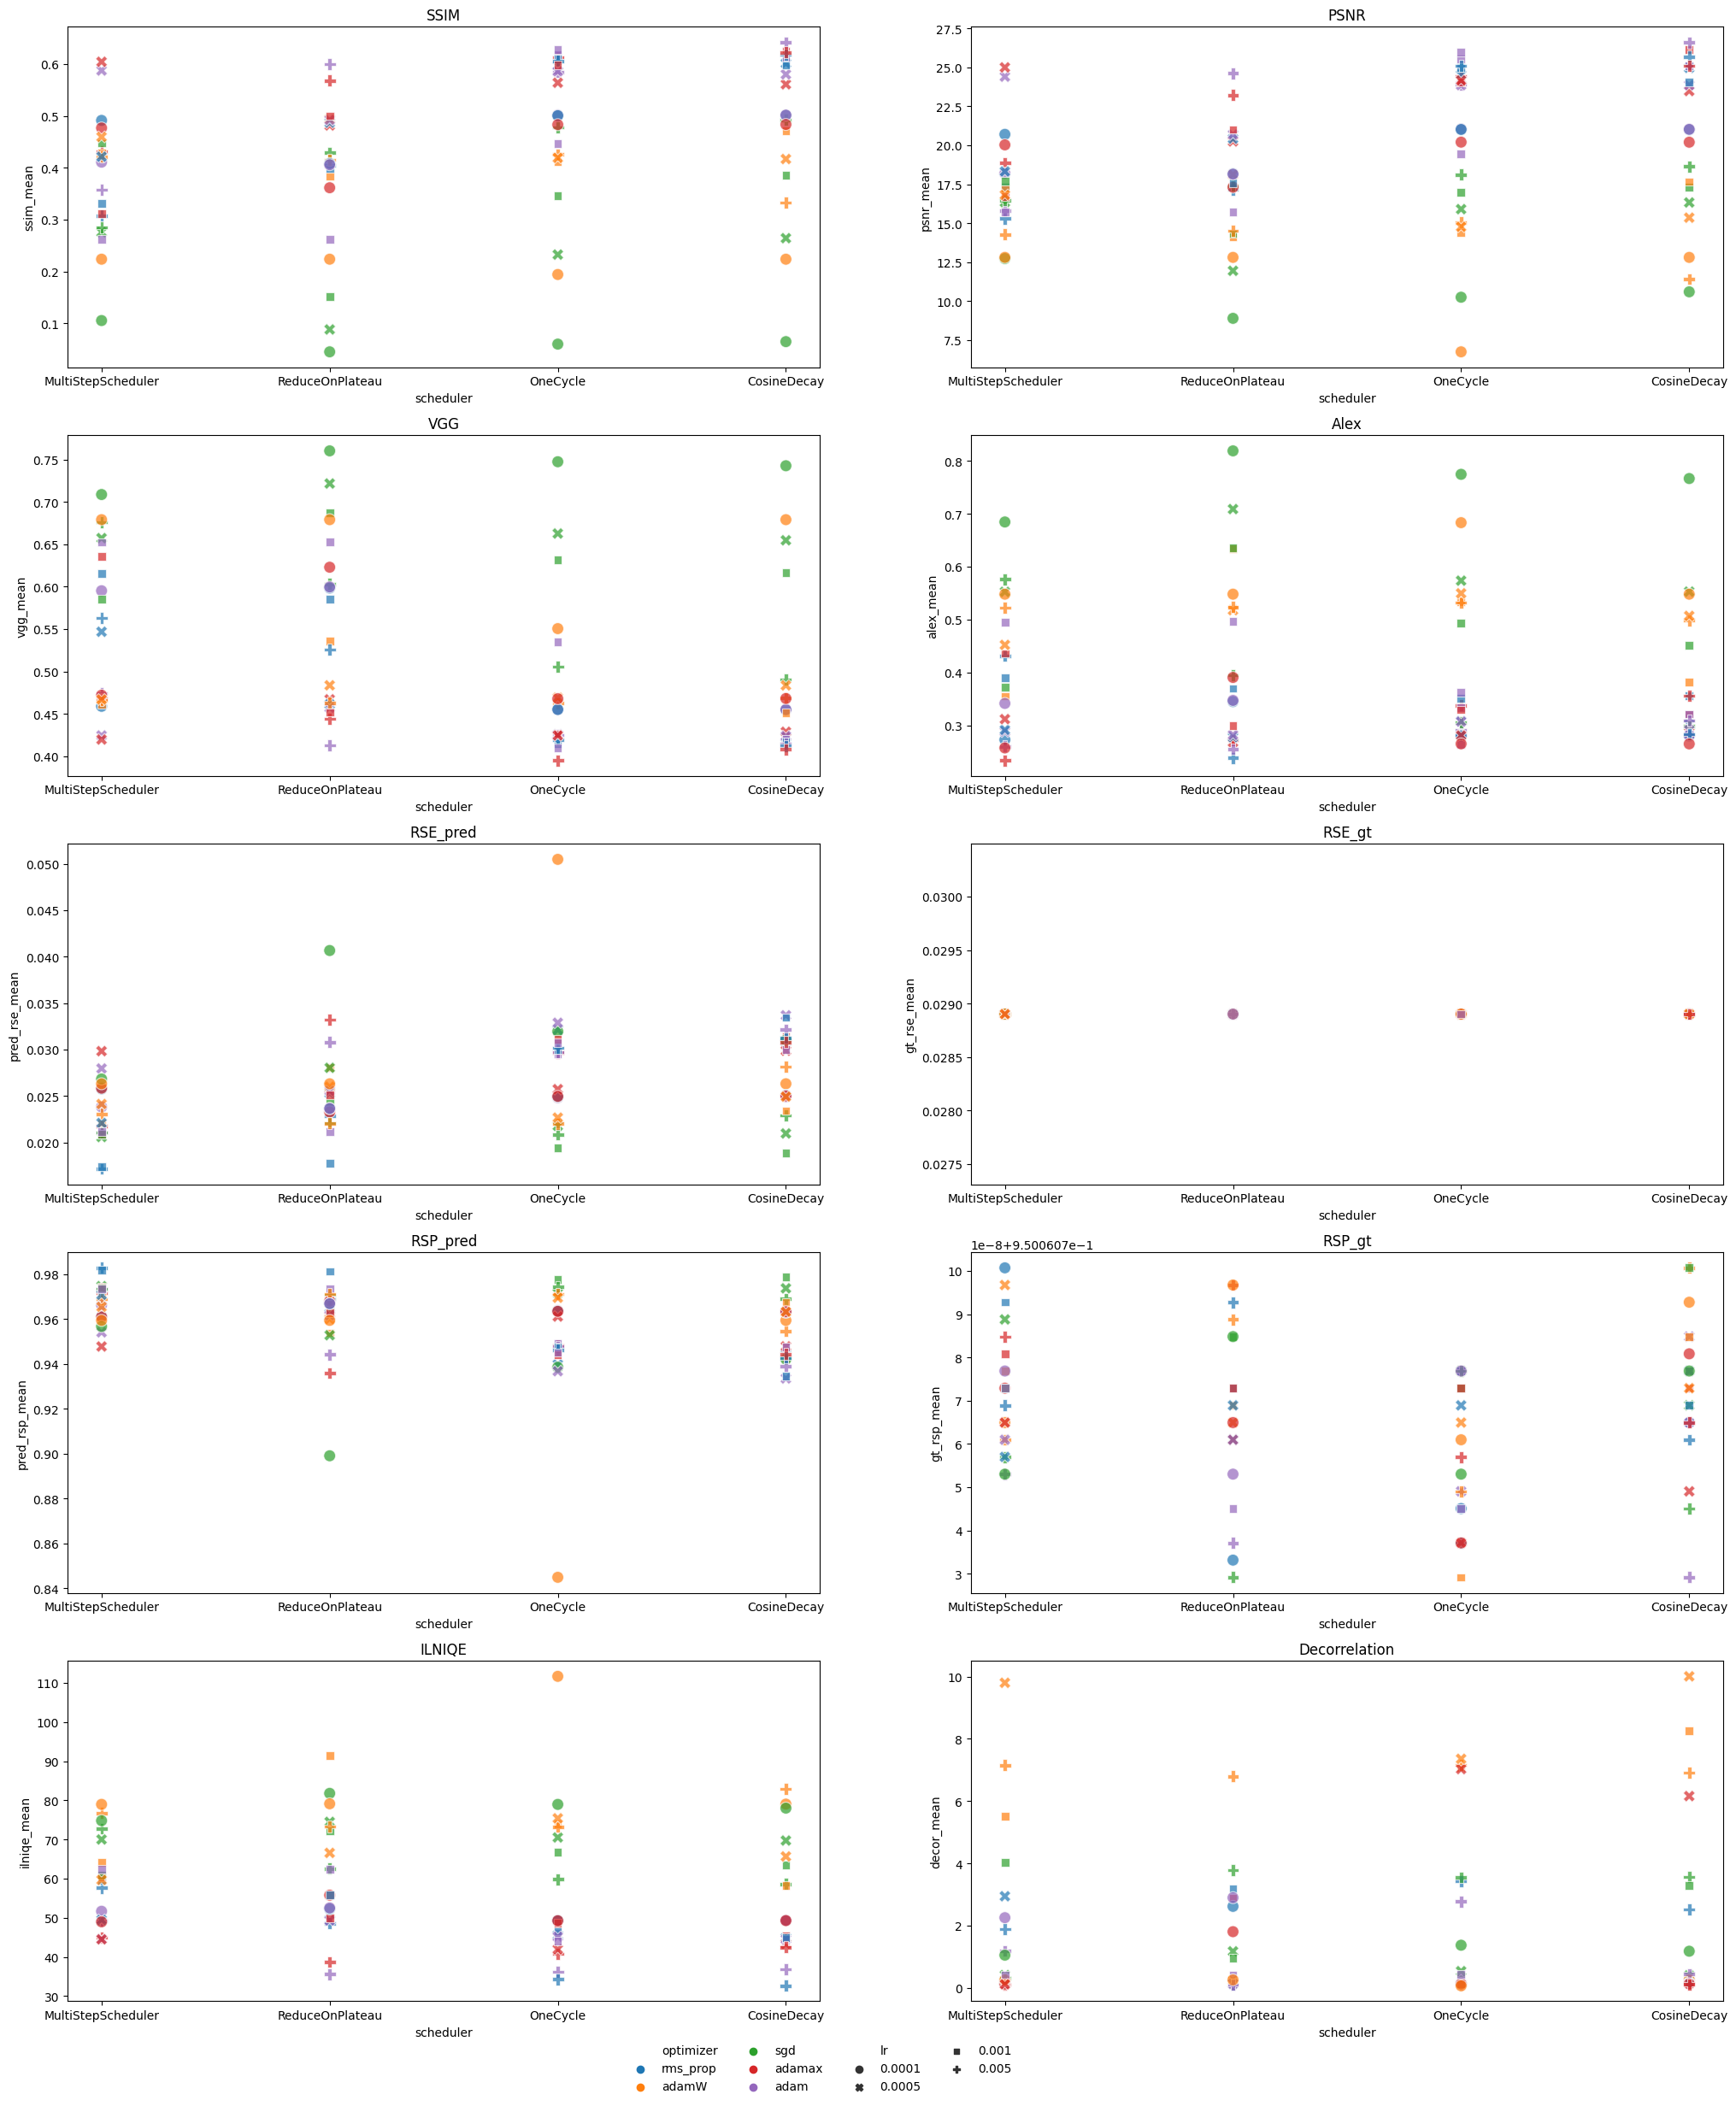

In [21]:
in_x_axis = "scheduler"
in_hue = "optimizer"

fig, axes = plt.subplots(5,2, figsize=(25,30))
axes[0,0].set_title('SSIM')
sns.scatterplot(data=filtered_df, ax=axes[0,0], y='ssim_mean', x=in_x_axis, s=100,
                hue=in_hue, style='lr', sizes=(40, 100), alpha=0.7, legend=False)

axes[0,1].set_title('PSNR')
sns.scatterplot(data=filtered_df, ax=axes[0,1], y='psnr_mean', x=in_x_axis,  s=100,
                hue=in_hue, style='lr', sizes=(40, 100), alpha=0.7, legend=False)

axes[1,0].set_title('VGG')
sns.scatterplot(data=filtered_df, ax=axes[1,0], y='vgg_mean', x=in_x_axis, s=100,
                hue=in_hue, style='lr', sizes=(40, 100), alpha=0.7, legend=False)

axes[1,1].set_title('Alex')
sns.scatterplot(data=filtered_df, ax=axes[1,1], y='alex_mean', x=in_x_axis, s=100,
                hue=in_hue, style='lr', alpha=0.7, legend=False)


axes[2,0].set_title('RSE_pred')
sns.scatterplot(data=filtered_df, ax=axes[2,0], y='pred_rse_mean', x=in_x_axis, s=100,
                hue=in_hue, style='lr', sizes=(40, 100), alpha=0.7, legend=False)

axes[2,1].set_title('RSE_gt')
sns.scatterplot(data=filtered_df, ax=axes[2,1], y='gt_rse_mean', x=in_x_axis, s=100,
                hue=in_hue, style='lr', alpha=0.7, legend=False)

axes[3,0].set_title('RSP_pred')
sns.scatterplot(data=filtered_df, ax=axes[3,0], y='pred_rsp_mean', x=in_x_axis, s=100,
                hue=in_hue, style='lr', sizes=(40, 100), alpha=0.7, legend=False)

axes[3,1].set_title('RSP_gt')
sns.scatterplot(data=filtered_df, ax=axes[3,1], y='gt_rsp_mean', x=in_x_axis, s=100,
                hue=in_hue, style='lr', alpha=0.7, legend=False)

axes[4,0].set_title('ILNIQE')
sns.scatterplot(data=filtered_df, ax=axes[4,0], y='ilniqe_mean', x=in_x_axis, s=100,
                hue=in_hue, style='lr', sizes=(40, 100), alpha=0.7, legend=False)

axes[4,1].set_title('Decorrelation')
sns.scatterplot(data=filtered_df, ax=axes[4,1], y='decor_mean', x=in_x_axis, s=100,
                hue=in_hue, style='lr', alpha=0.7)
sns.move_legend(
    axes[4,1], "lower center",
    bbox_to_anchor=(-0.2, -0.3), ncol=4, title=None, frameon=False,
)

# Export the information for the excel

In [20]:
desired_dataset = 'F-actin' # 'LiveFActinDataset', 'EM', 'MitoTracker_small', 'F-actin', 'ER', 'MT', 'MT-SMLM_all'

excel_df = df.copy()
excel_df = excel_df[excel_df['dataset_name'] == desired_dataset]
excel_df = excel_df[['model_name', 'input_data_shape', 'output_data_shape', 
                     'crappifier', 'scale','actual_scale_factor',
                     'seed', 'batch_size', 'num_epochs', 'patience', 'validation_split', 
                     'additional_folder', 'data_augmentation', 'datagen_sampling_pdf',
                     'lr', 'discriminator_lr',
                     'optimizer', 'discriminator_optimizer', 
                     'scheduler', 'discriminator_lr_scheduler', 
                     'mse_mean', 'mse_std',  
                     'psnr_mean', 'psnr_std', 
                     'ssim_mean', 'ssim_std',                     
                     'vgg_mean', 'vgg_std', 
                     'alex_mean', 'alex_std']]
                     
print(excel_df.sort_values(by=['mse_mean'], ascending=True).head(1).index)
print(excel_df.sort_values(by=['psnr_mean'], ascending=False).head(1).index)
print(excel_df.sort_values(by=['ssim_mean'], ascending=False).head(1).index)
print(excel_df.sort_values(by=['vgg_mean'], ascending=True).head(1).index)
print(excel_df.sort_values(by=['alex_mean'], ascending=True).head(1).index)

excel_df

Index(['dfcan_F-actin_6'], dtype='object')
Index(['dfcan_F-actin_6'], dtype='object')
Index(['dfcan_F-actin_0'], dtype='object')
Index(['rcan_F-actin_93'], dtype='object')
Index(['wgan_F-actin_9'], dtype='object')


model_name  input_data_shape   output_data_shape  \
wgan_F-actin_0         wgan               NaN                 NaN   
wgan_F-actin_1         wgan               NaN                 NaN   
wgan_F-actin_2         wgan               NaN                 NaN   
wgan_F-actin_3         wgan               NaN                 NaN   
wgan_F-actin_4         wgan  [372, 64, 64, 1]  [372, 128, 128, 1]   
wgan_F-actin_5         wgan  [372, 64, 64, 1]  [372, 128, 128, 1]   
wgan_F-actin_6         wgan               NaN                 NaN   
wgan_F-actin_7         wgan               NaN                 NaN   
wgan_F-actin_8         wgan               NaN                 NaN   
wgan_F-actin_9         wgan  [372, 64, 64, 1]  [372, 128, 128, 1]   
wgan_F-actin_10        wgan               NaN                 NaN   
wgan_F-actin_11        wgan               NaN                 NaN   
wgan_F-actin_12        wgan               NaN                 NaN   
wgan_F-actin_13        wgan               NaN                 NaN   
wgan_F-actin_14        wgan               NaN                 NaN   
wgan_F-actin_15        wgan               NaN                 NaN   
wgan_F-actin_16        wgan               NaN                 NaN   
wgan_F-actin_17        wgan               NaN                 NaN   
wgan_F-actin_18        wgan               NaN                 NaN   
wgan_F-actin_19        wgan               NaN                 NaN   
wgan_F-actin_20        wgan               NaN                 NaN   
wgan_F-actin_21        wgan               NaN                 NaN   
wgan_F-actin_22        wgan               NaN                 NaN   
wgan_F-actin_23        wgan               NaN                 NaN   
wdsr_F-actin_0         wdsr  [372, 64, 64, 1]  [372, 128, 128, 1]   
wdsr_F-actin_1         wdsr  [372, 64, 64, 1]  [372, 128, 128, 1]   
wdsr_F-actin_2         wdsr  [372, 64, 64, 1]  [372, 128, 128, 1]   
wdsr_F-actin_3         wdsr  [372, 64, 64, 1]  [372, 128, 128, 1]   
wdsr_F-actin_4         wdsr  [372, 64, 64, 1]  [372, 128, 128, 1]   
wdsr_F-actin_5         wdsr  [372, 64, 64, 1]  [372, 128, 128, 1]   
wdsr_F-actin_6         wdsr  [372, 64, 64, 1]  [372, 128, 128, 1]   
wdsr_F-actin_7         wdsr  [372, 64, 64, 1]  [372, 128, 128, 1]   
wdsr_F-actin_8         wdsr  [372, 64, 64, 1]  [372, 128, 128, 1]   
wdsr_F-actin_9         wdsr  [372, 64, 64, 1]  [372, 128, 128, 1]   
wdsr_F-actin_10        wdsr  [372, 64, 64, 1]  [372, 128, 128, 1]   
wdsr_F-actin_11        wdsr  [372, 64, 64, 1]  [372, 128, 128, 1]   
wdsr_F-actin_12        wdsr  [372, 64, 64, 1]  [372, 128, 128, 1]   
wdsr_F-actin_13        wdsr  [372, 64, 64, 1]  [372, 128, 128, 1]   
wdsr_F-actin_14        wdsr  [372, 64, 64, 1]  [372, 128, 128, 1]   
wdsr_F-actin_15        wdsr  [372, 64, 64, 1]  [372, 128, 128, 1]   
dfcan_F-actin_0       dfcan               NaN                 NaN   
dfcan_F-actin_1       dfcan  [372, 64, 64, 1]  [372, 128, 128, 1]   
dfcan_F-actin_2       dfcan  [372, 64, 64, 1]  [372, 128, 128, 1]   
dfcan_F-actin_3       dfcan               NaN                 NaN   
dfcan_F-actin_4       dfcan               NaN                 NaN   
dfcan_F-actin_5       dfcan  [372, 64, 64, 1]  [372, 128, 128, 1]   
dfcan_F-actin_6       dfcan               NaN                 NaN   
dfcan_F-actin_7       dfcan               NaN                 NaN   
dfcan_F-actin_8       dfcan               NaN                 NaN   
dfcan_F-actin_9       dfcan               NaN                 NaN   
dfcan_F-actin_10      dfcan               NaN                 NaN   
dfcan_F-actin_11      dfcan               NaN                 NaN   
dfcan_F-actin_12      dfcan               NaN                 NaN   
dfcan_F-actin_13      dfcan               NaN                 NaN   
dfcan_F-actin_14      dfcan  [372, 64, 64, 1]  [372, 128, 128, 1]   
dfcan_F-actin_15      dfcan               NaN                 NaN   
rcan_F-actin_0         rcan  [372, 64, 64, 1]  [372, 128, 128, 1]   
rcan_F-actin_1 